<p style ="text-align:center; font-weight: bold; font-style: italic; font-size: 40px;">
Predicting Obesity Risk with Machine Learning Using NHANES Data

***
<font color="Gray">**Authors:**</font></br>
Nazanin Ghaemi-Zadeh (402200842)</br>
Zahra Peyvandi (403209624)</br>

<font color="Gray">**Instructor:**</font></br>
Dr. Nafiseh Sedghi

***
### <font color="White">***Table of Contents***</font></br>
0. [Libraries](#0.)
1. [Data Collection](#1.)
2. [Data Filtering](#2.)
3. [Data Transformation](#3.)
4. [Data Imputation](#4.)
5. [Target Variable Analysis](#5.)
6. [Train and Test Splitting](#6.)
7. [Model Development](#7.)
    - [7.1. Polytomous Logistic Regression](#7-1.)
    - [7.2. Decision Tree](#7-2.)
    - [7.3. Random Forest](#7-3.)
    - [7.4. Support Vector Machine](#7-4.)
    - [7.5. K-Nearest Neighbors](#7.5.)
8. [Performance Comparison](#8.)
    - [8.1. Train data](#8-1.)
    - [8.2. Test Data](#8-2.)
9. [Best Method Selection](#9.)
***

## **0. Libraries** <a id = 0></a>

In [ ]:
# Load necessary libraries
library(dplyr)        # For efficient data manipulation and transformation
library(tidyverse)    # Comprehensive collection of tools for data science (e.g., ggplot2, tidyr, dplyr)
library(haven)        # For importing/exporting data
library(mice)         # For handling missing data using multiple imputation techniques
library(moments)      # For calculating statistical moments like skewness and kurtosis
library(GGally)       # For visualizing data relationships and patterns
library(caTools)      # For splitting data into training and testing sets
library(randomForest) # For building and training random forest models
library(rpart)        # For creating decision tree models
library(rpart.plot)   # For visualizing decision trees
library(caret)        # For machine learning workflows and model evaluation
library(e1071)        # For implementing SVM, Naive Bayes, and other ML models
library(kernlab)      # Specialized in kernel-based machine learning methods, such as SVM.
library(nnet)         # For neural networks and multi-nomial logistic regression
library(lars)         # For least-angle regression (LAR) and related methods
library(MASS)         # Statistical functions and GLM support
library(reshape2)     # For reshaping data between wide and long formats
library(ROCR)         # For evaluating models with ROC curves and performance metrics

## **1. Data Collection** <a id = 1></a>

<p style="text-align: justify;">
The code processes NHANES data from multiple year ranges (2011-2018) by defining folder paths for each dataset. It includes a function, `read_and_merge`, which reads `.XPT` files from each folder, merges them using the common identifier `SEQN`, and returns cleaned datasets. These datasets are then combined across all years using `bind_rows` to form a single consolidated dataset. Finally, a predefined set of selected features is extracted, ensuring the resulting dataset includes only the variables necessary for subsequent analysis. This prepares the data for efficient machine learning or statistical workflows.
<p>

In [2]:
# Define folders for each year range
folders <- c(
  "E:/2. M.S. Sharif University of Technology/Courses/Operations Analytics/Project/NHANES Data/2017-2018",
  "E:/2. M.S. Sharif University of Technology/Courses/Operations Analytics/Project/NHANES Data/2015-2016",
  "E:/2. M.S. Sharif University of Technology/Courses/Operations Analytics/Project/NHANES Data/2013-2014",
  "E:/2. M.S. Sharif University of Technology/Courses/Operations Analytics/Project/NHANES Data/2011-2012"
)

# Define a function to read and clean datasets from each folder
read_and_merge <- function(folder) {
  paths <- list.files(folder, pattern = "\\.XPT$", full.names = TRUE) # List all .XPT files in the specified folder
  datasets <- map(paths, read_xpt)  # Load each .XPT file as a dataset using the read_xpt function, storing them in a list
  reduce(datasets, inner_join, by = "SEQN")  # Merge all datasets within the folder based on the common column 'SEQN'
}

# Read and merge all datasets from each folder
merged_data_list <- map(folders, read_and_merge) # Apply the 'read_and_merge' function to each folder in the 'folders' vector

# Combine datasets across different folders using bind_rows
combined_data <- bind_rows(merged_data_list) # Combine all data frames into a single data frame

# Define the selected features as a vector
selected_features <- c("SEQN", 
                       "RIAGENDR", "RIDAGEYR",
                       "RIDEXPRG",
                       "PAD615", "PAD630", "PAD660", "PAD675",
                       "SLD012", "SLQ120",
                       "DBQ700",
                       "BMXWT", "BMXHT", "BMXBMI", "BMXWAIST", "BMXHIP",
                       "DXDTOPF", "DXDSTLE", "DXDSTLI",
                       "BPXDI1", "BPXSY1",
                       "LBXGH", "LBXGLU", "LBXIN", "LBXTR", "LBXSUA", "LBXTC", "LBDHDD", "LBDLDLSI",
                       "URXUCR",
                       "LBXHSCRP",
                       "LBXSATSI", "LBXSASSI",
                       "LBXPLTSI", "LBXRBCSI", "LBXWBCSI",
                       "LBXSAL", "LBXSTP", "LBXSGB"
)

# Select columns based on selected features
data <- combined_data %>%
  dplyr::select(all_of(selected_features)) # Select only the columns specified in 'selected_features'

In [3]:
# Display the first few rows of the dataset
head(data)

SEQN,RIAGENDR,RIDAGEYR,RIDEXPRG,PAD615,PAD630,PAD660,PAD675,SLD012,SLQ120,⋯,URXUCR,LBXHSCRP,LBXSATSI,LBXSASSI,LBXPLTSI,LBXRBCSI,LBXWBCSI,LBXSAL,LBXSTP,LBXSGB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
93711,1,56,NA,NA,NA,60,30,7.0,3,⋯,98,0.82,20,23,264,4.65,5.0,4.0,7.1,3.1
93717,1,22,NA,NA,NA,NA,NA,8.0,1,⋯,230,0.80,13,17,238,4.82,5.5,4.3,7.6,3.3
93718,1,45,NA,NA,NA,NA,60,8.0,2,⋯,71,0.69,13,17,272,4.71,6.2,4.2,7.2,3.0
93731,1,20,NA,NA,240,120,60,9.0,2,⋯,255,0.75,22,14,261,5.58,8.8,4.5,7.5,3.0
93735,1,52,NA,NA,NA,NA,NA,5.5,2,⋯,NA,1.59,9,11,120,3.79,6.3,3.8,7.0,3.2
93738,1,26,NA,480,180,60,NA,7.0,1,⋯,241,5.26,23,26,259,5.56,7.0,4.3,7.5,3.2


<p style="text-align: justify;">
This step makes the dataset more user-friendly by applying meaningful column names, which enhances interpretability and facilitates further analysis or reporting.
<p>

In [4]:
# Renaming the columns of the data frame for better readability and usability
colnames(data) <- c(
    "Seq",                          # Sequential number (ID or index of the row)
    "Gender",                       # Gender of the individual
    "Age",                          # Age of the individual
    "Pregnancy",                    # Pregnancy status (if applicable)
    "Vigorous_Work",                # Minutes of vigorous-intensity work
    "Moderate_Work",                # Minutes of moderate-intensity work
    "Vigorous_Activity",            # Minutes of vigorous recreational activities
    "Moderate_Activity",            # Minutes of moderate recreational activities
    "Sleep_Hours",                  # Number of sleep hours on weekdays/workdays
    "Sleepiness_Frequency",         # Frequency of feeling overly sleepy during the day
    "Diet_Healthiness",             # Self-reported healthiness of the diet
    "Weight",                       # Weight of the individual in kilograms
    "Height",                       # Height of the individual in centimeters
    "BMI",                          # Body Mass Index (kg/m²)
    "Waist_Circumference",          # Waist circumference in centimeters
    "Hip_Circumference",            # Hip circumference in centimeters
    "Fat_Percent",                  # Percentage of body fat
    "Lean_Mass_Excl_BMC",           # Lean mass excluding Bone Mineral Content (BMC) in grams
    "Lean_Mass_Incl_BMC",           # Lean mass including BMC in grams
    "Diastolic_BP",                 # Diastolic blood pressure (first reading, mmHg)
    "Systolic_BP",                  # Systolic blood pressure (first reading, mmHg)
    "Glycohemoglobin",              # Percentage of glycohemoglobin (HbA1c)
    "Fasting_Glucose",              # Fasting glucose level (mg/dL)
    "Insulin",                      # Insulin level (uU/mL)
    "Triglyceride",                 # Triglyceride level (mg/dL)
    "Uric_Acid",                    # Uric acid level (mg/dL)
    "Total_Cholesterol",            # Total cholesterol level (mg/dL)
    "HDL_Cholesterol",              # High-density lipoprotein cholesterol level (mg/dL)
    "LDL_Cholesterol",              # Low-density lipoprotein cholesterol level (mg/dL)
    "Urine_Creatinine",             # Creatinine level in urine (mg/dL)
    "C-Reactive_Protein",           # High-sensitivity C-reactive protein (mg/L)
    "Alanine_Aminotransferase",     # Alanine aminotransferase (ALT) enzyme level (U/L)
    "Aspartate_Aminotransferase",   # Aspartate aminotransferase (AST) enzyme level (U/L)
    "Platelet_Count",               # Platelet count (1000 cells/uL)
    "Red_Blood_Count",              # Red blood cell count (million cells/uL)
    "White_Blood_Count",            # White blood cell count (1000 cells/uL)
    "Albumin",                      # Serum albumin level (g/dL)
    "Total_Protein",                # Total protein level in serum (g/dL)
    "Globulin"                      # Globulin level (g/dL)
)

# Display the first few rows of the dataset to check column names
head(data)

Seq,Gender,Age,Pregnancy,Vigorous_Work,Moderate_Work,Vigorous_Activity,Moderate_Activity,Sleep_Hours,Sleepiness_Frequency,⋯,Urine_Creatinine,C-Reactive_Protein,Alanine_Aminotransferase,Aspartate_Aminotransferase,Platelet_Count,Red_Blood_Count,White_Blood_Count,Albumin,Total_Protein,Globulin
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
93711,1,56,NA,NA,NA,60,30,7.0,3,⋯,98,0.82,20,23,264,4.65,5.0,4.0,7.1,3.1
93717,1,22,NA,NA,NA,NA,NA,8.0,1,⋯,230,0.80,13,17,238,4.82,5.5,4.3,7.6,3.3
93718,1,45,NA,NA,NA,NA,60,8.0,2,⋯,71,0.69,13,17,272,4.71,6.2,4.2,7.2,3.0
93731,1,20,NA,NA,240,120,60,9.0,2,⋯,255,0.75,22,14,261,5.58,8.8,4.5,7.5,3.0
93735,1,52,NA,NA,NA,NA,NA,5.5,2,⋯,NA,1.59,9,11,120,3.79,6.3,3.8,7.0,3.2
93738,1,26,NA,480,180,60,NA,7.0,1,⋯,241,5.26,23,26,259,5.56,7.0,4.3,7.5,3.2


In [5]:
# Display the dataset dimensions
cat("Dataset shape:", dim(data), "\n")

Dataset shape: 7837 39 


In [6]:
# Export the dataset to a CSV file
write.csv(
    data,
    "E:/2. M.S. Sharif University of Technology/Courses/Operations Analytics/Project/Final_Data.csv",
    row.names = FALSE
    )

## **2. Data Filtering** <a id = 2></a>

<p style="text-align: justify;">
The code calculates Body Water (TBW) and Basal Metabolic Rate (BMR) using gender-specific formulas for TBW and BMR. These metrics are added as new columns to the dataset for further analysis.
<p>

In [7]:
# Calculate additional metrics for the dataset
data <- data %>%
  
  # Add a new column for Body Water (Litres) based on Watson formula
  mutate(
    Body_water = ifelse(
      Gender == 1, # Use the formula for men if Gender == 1
      2.447 - (0.09145 * Age) + (0.1074 * Height) + (0.3362 * Weight), # Watson formula for men
      -2.097 + (0.1069 * Height) + (0.2466 * Weight) # Watson formula for women
    )
  ) %>%
  
  # Add a new column for Basal Metabolic Rate (Calories/Day) based on provided formulas
  mutate(
    Basal_Metabolism_Rate = ifelse(
      Gender == 1, # Use the formula for men if Gender == 1
      88.362 + (13.397 * Weight) + (4.799 * Height) - (5.677 * Age), # BMR formula for men
      447.593 + (9.247 * Weight) + (3.098 * Height) - (4.330 * Age) # BMR formula for women
    )
  )

<p style="text-align: justify;">
The code calculates the correlation between a response variable (here, "BMI") and other numeric features in the dataset. This helps in understanding how strongly each feature relates to the response variable, aiding feature selection or further analysis.
<p>

In [8]:
# Identify numeric variables in the dataset
numeric_vars <- data %>%
  dplyr::select(where(is.numeric)) %>%
  colnames()

# Initialize an empty data frame to store correlations
correlation_df <- data.frame(Variable = character(), Correlation = numeric(), stringsAsFactors = FALSE)

# Loop through numeric variables to calculate correlations
for (var in numeric_vars) {
  if (!var %in% c("BMI", "Seq")) { # Exclude BMI and Seq
    correlation <- cor(data[[var]], data$BMI, use = "complete.obs") # Handle missing values
    correlation_df <- rbind(correlation_df, data.frame(Variable = var, Correlation = correlation))
  }
}

# View the resulting data frame
correlation_df

Variable,Correlation
<chr>,<dbl>
Gender,0.076323075
Age,0.180456849
Pregnancy,0.031621156
Vigorous_Work,-0.024070284
Moderate_Work,0.002062534
Vigorous_Activity,-0.040269271
Moderate_Activity,-0.019086368
Sleep_Hours,-0.066293780
Sleepiness_Frequency,0.109689715


<p style="text-align: justify;">
The code calculates the proportion of missing values for each column in the dataset and visualizes the results in a bar plot. This provides a clear visualization of the extent of missing data in the dataset.
<p>

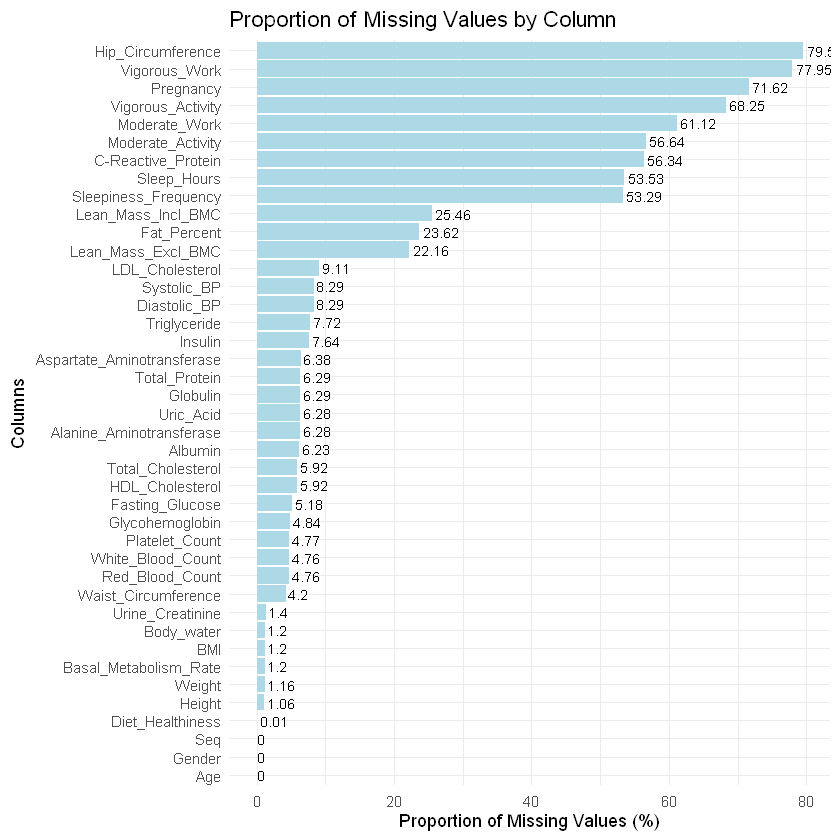

In [9]:
# Initialize an empty data frame to store the proportions
missing_value_proportion <- data.frame(Column = character(), Proportion = numeric(), stringsAsFactors = FALSE)

# Loop over each column index in the data
for (i in 1:ncol(data)) {
    # Calculate the proportion of missing values for the column
    proportion <- round(sum(is.na(data[, i])) / nrow(data) * 100, 3)
    
    # Add the column name and proportion to the data frame
    missing_value_proportion <- rbind(missing_value_proportion, data.frame(Column = colnames(data)[i], Proportion = proportion))
}

# Create bar plot
ggplot(missing_value_proportion, aes(x = reorder(Column, Proportion), y = Proportion)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  coord_flip() +
  geom_text(aes(label = round(Proportion, 2)), hjust = -0.1, size = 3) +
  labs(title = "Proportion of Missing Values by Column",
       x = "Columns",
       y = "Proportion of Missing Values (%)") +
       theme_minimal()

<p style="text-align: justify;">
The code updates the Pregnancy column in the dataset by replacing numeric codes with descriptive labels ("Yes," "No," "Cannot Ascertain").
It then creates a bar chart displaying the distribution of pregnancy statuses, showing the counts as labels on top of the bars. <p>

Warning message:
"The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead."


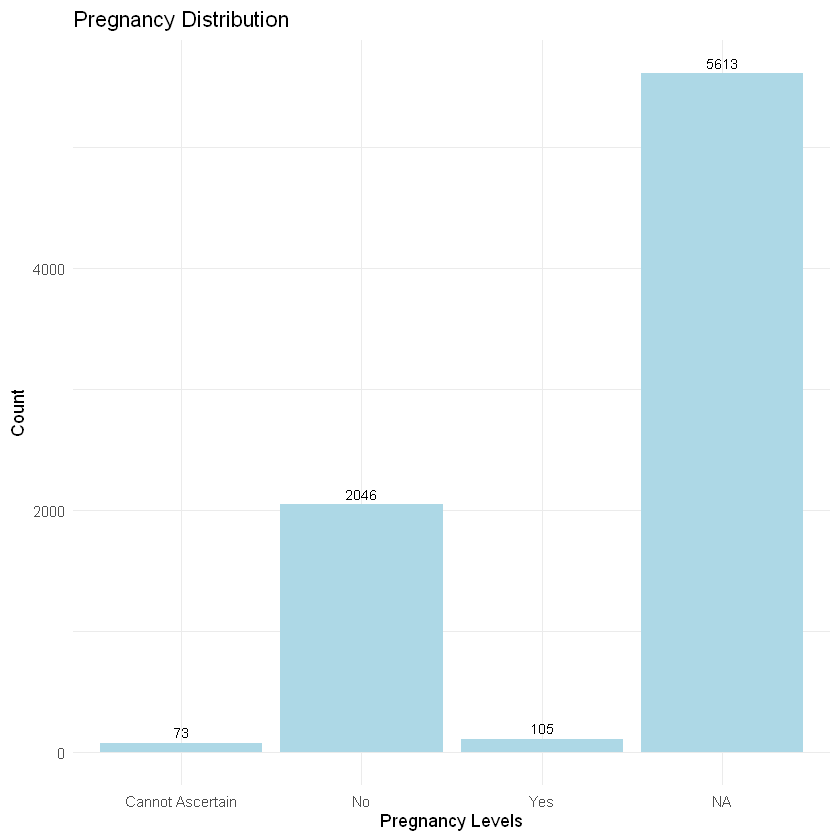

In [10]:
# Update the Gender column with new class names
data <- data %>% 
  mutate(Pregnancy = case_when(
    Pregnancy == 1 ~ "Yes",
    Pregnancy == 2 ~ "No",
    Pregnancy == 3 ~ "Cannot Ascertain"
  ))

# Create a bar chart for Pregnancy status 
ggplot(data, mapping = aes(x = Pregnancy)) +
  geom_bar(fill = "lightblue") +
  geom_text(stat = "count", aes(label = ..count..), vjust = -0.5, size = 3) +
  labs(title = "Pregnancy Distribution",
       x = "Pregnancy Levels",
       y = "Count") +
  theme_minimal()

<p style="text-align: justify;">
The code filters and cleans the dataset by performing several steps: it first retains rows where the Pregnancy status is not Yes, then further filters the data to include only adults aged 18 or older. Afterward, the Pregnancy column is removed, and any columns with a proportion of missing values exceeding the defined threshold (30%) are dynamically excluded.
<p>

In [11]:
# Define the threshold for high missing values
missing_threshold <- 0.3

# Filter the dataset to include only rows where Pregnancy is No, Cannot Ascertain, or NA
data <- data %>% 
    dplyr::filter(Pregnancy %in% c("No", "Cannot Ascertain", NA)) %>% 

    # Further filter the dataset to include only adults (Age 18 or older)
    dplyr::filter(Age >= 18) %>% 

    # Remove the Pregnancy column from the dataset
    dplyr::select(-Pregnancy) %>%

    # Remove the most correlated columns from the dataset
    dplyr::select(-c(Waist_Circumference, Weight, Height)) %>%

    # Dynamically remove columns with more than the defined proportion of missing values
    dplyr::select(where(~ mean(is.na(.)) <= missing_threshold)) 

# Display the dimensions of the filtered dataset (number of rows and columns)
cat("Dataset shape:", dim(data), "\n")

Dataset shape: 7272 29 


## **3. Data Transformation** <a id = 3></a>

In [12]:
# Update the Gender column with new class names
data <- data %>% 
  mutate(Gender = case_when(
    Gender == 1 ~ "Male",
    Gender == 2 ~ "Female"
  ))

# Update the Diet_Healthiness column with new class names
data <- data %>%
  mutate(Diet_Healthiness = case_when(
    Diet_Healthiness == 1 ~ "Excellent",
    Diet_Healthiness == 2 ~ "Very Good",
    Diet_Healthiness == 3 ~ "Good",
    Diet_Healthiness == 4 ~ "Fair",
    Diet_Healthiness == 5 ~ "Poor",
    Diet_Healthiness == 7 ~ "Refused",
    Diet_Healthiness == 9 ~ "Don’t know",
    TRUE ~ as.character(Diet_Healthiness) # Preserve other values if any
  ))

In [13]:
# Convert to character type
data$Seq <- as.character(data$Seq)

# Convert to factor type
data$Gender <- as.factor(data$Gender)
data$Diet_Healthiness <- as.factor(data$Diet_Healthiness)

## **4. Data Imputation** <a id = 4></a>

<p style="text-align: justify;">
The code computes summary statistics for all numeric variables in a dataset to aid in understanding their distribution, which is crucial for selecting an appropriate imputation method. First, it filters numeric columns using select(where(is.numeric)). Then, it iterates through each numeric variable, calculating key statistics like minimum, first quartile, mean, median, third quartile, maximum, skewness, and kurtosis, rounding them for clarity. These statistics, combined into a data frame with variable names, provide insights into the central tendency, variability, and shape of the distributions. 
<p>

In [14]:
# Create an empty data frame to store results
numeric_summary <- data.frame()

# Select only numeric variables
numeric_data <- data %>% dplyr::select(where(is.numeric))

# Loop through each numeric column
for (var in names(numeric_data)) {
  stats <- c(
    Min = round(min(numeric_data[[var]], na.rm = TRUE), 2),
    First_Quantile = round(quantile(numeric_data[[var]], 0.25, na.rm = TRUE), 2),
    Mean = round(mean(numeric_data[[var]], na.rm = TRUE), 2),
    Median = round(median(numeric_data[[var]], na.rm = TRUE), 2),
    Third_Quantile = round(quantile(numeric_data[[var]], 0.75, na.rm = TRUE), 2),
    Max = round(max(numeric_data[[var]], na.rm = TRUE), 2),
    Skewness = round(skewness(numeric_data[[var]], na.rm = TRUE), 2),
    Kurtosis = round(kurtosis(numeric_data[[var]], na.rm = TRUE), 2)
  )
  
  # Combine results into a data frame
  numeric_summary <- rbind(numeric_summary, stats)
}

# Add a column for variable names
numeric_summary <- data.frame(Variable = names(numeric_data), numeric_summary)

# Add column names for statistics
colnames(numeric_summary) <- c("Variable", "Min", "1st_Qu", "Mean", "Median", "3rd_Qu", "Max", "Skewness", "Kurtosis")

# Display the summary
numeric_summary

Variable,Min,1st_Qu,Mean,Median,3rd_Qu,Max,Skewness,Kurtosis
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Age,18.00,27.00,38.14,38.00,49.00,59.00,-0.02,-1.21
BMI,13.60,23.60,29.02,27.70,32.70,86.20,1.28,2.88
Fat_Percent,11.70,26.10,32.69,32.30,39.70,55.40,-0.02,-0.79
Lean_Mass_Excl_BMC,21538.40,39018.60,48274.23,47543.90,56146.20,107447.80,0.53,0.18
Lean_Mass_Incl_BMC,22554.70,40649.02,50180.51,49553.40,58344.58,110602.90,0.50,0.13
Diastolic_BP,0.00,64.00,70.91,70.00,78.00,124.00,-0.10,2.32
Systolic_BP,66.00,108.00,118.96,116.00,126.00,236.00,1.17,3.18
Glycohemoglobin,3.50,5.20,5.62,5.40,5.70,16.50,4.25,24.06
Fasting_Glucose,21.00,92.00,105.61,98.00,107.00,454.00,4.79,28.74


<p style="text-align: justify;">
The code uses the mice package to perform multiple imputations on a dataset with missing values, specifying imputation methods for each variable in a methods vector. Most numeric variables use predictive mean matching (pmm), while categorical variables like Diet_Healthiness use polytomous logistic regression (polyreg), and some variables with no missing data are left as is (""). The mice function performs imputation with one iteration (m = 1), running for five iterations (maxit = 5) with a fixed seed for reproducibility. The first complete dataset is extracted using complete(), and the imputed dataset is saved as a CSV file (Imputed_Data.csv) for further analysis.
<p>

In [15]:
# Define imputation methods for each variable
methods <- c(
  "",                    # Seq (no imputation needed)
  "",                    # Gender (no imputation needed)
  "pmm",                 # Age
  "polyreg",             # Diet_Healthiness (polytomous logistic regression)
  "pmm",                 # BMI
  "pmm",                 # Fat_Percent
  "pmm",                 # Lean_Mass_Excl_BMC
  "pmm",                 # Lean_Mass_Incl_BMC
  "pmm",                 # Diastolic_BP
  "pmm",                 # Systolic_BP
  "pmm",                 # Glycohemoglobin
  "pmm",                 # Fasting_Glucose
  "pmm",                 # Insulin
  "pmm",                 # Triglyceride
  "pmm",                 # Uric_Acid
  "pmm",                 # Total_Cholesterol
  "pmm",                 # HDL_Cholesterol
  "pmm",                 # LDL_Cholesterol
  "pmm",                 # Urine_Creatinine
  "pmm",                 # Alanine_Aminotransferase
  "pmm",                 # Aspartate_Aminotransferase
  "pmm",                 # Platelet_Count
  "pmm",                 # Red_Blood_Count
  "pmm",                 # White_Blood_Count
  "pmm",                 # Albumin
  "pmm",                 # Total_Protein
  "pmm",                 # Globulin
  "pmm",                 # Body_water
  "pmm"                  # Basal_Metabolism_Rate
)

# Perform imputation using the mice package with the specified methods
Imputed_Data <- mice(data, method = methods, m = 1, maxit = 5, seed = 555)

# Extract the first complete dataset from the imputed data
complete_data <- complete(Imputed_Data, 1)

# Save the complete dataset to a CSV file
write.csv(complete_data, "Imputed_Data.csv", row.names = FALSE)


 iter imp variable
  1   1  BMI  Fat_Percent  Lean_Mass_Excl_BMC  Diastolic_BP  Systolic_BP  Glycohemoglobin  Fasting_Glucose  Insulin  Triglyceride  Uric_Acid  Total_Cholesterol  HDL_Cholesterol  LDL_Cholesterol  Urine_Creatinine  Alanine_Aminotransferase  Aspartate_Aminotransferase  Platelet_Count  Red_Blood_Count  White_Blood_Count  Albumin  Total_Protein  Globulin  Body_water  Basal_Metabolism_Rate
  2   1  BMI  Fat_Percent  Lean_Mass_Excl_BMC  Diastolic_BP  Systolic_BP  Glycohemoglobin  Fasting_Glucose  Insulin  Triglyceride  Uric_Acid  Total_Cholesterol  HDL_Cholesterol  LDL_Cholesterol  Urine_Creatinine  Alanine_Aminotransferase  Aspartate_Aminotransferase  Platelet_Count  Red_Blood_Count  White_Blood_Count  Albumin  Total_Protein  Globulin  Body_water  Basal_Metabolism_Rate
  3   1  BMI  Fat_Percent  Lean_Mass_Excl_BMC  Diastolic_BP  Systolic_BP  Glycohemoglobin  Fasting_Glucose  Insulin  Triglyceride  Uric_Acid  Total_Cholesterol  HDL_Cholesterol  LDL_Cholesterol  Urine_Creat

Warning message:
"Number of logged events: 122"


<p style="text-align: justify;">
After imputing most variables with mice, it is noted that the Lean_Mass_Incl_BMC variable could not be imputed by mice due to potential issues with its data or imputation settings. To handle this, missing values in Lean_Mass_Incl_BMC are manually imputed by replacing them with the mean of the non-missing values.
<p>

In [16]:
# Replace NA values in "Lean_Mass_Incl_BMC"
complete_data$Lean_Mass_Incl_BMC[is.na(complete_data$Lean_Mass_Incl_BMC)] <- mean(complete_data$Lean_Mass_Incl_BMC, na.rm = TRUE)

<p style="text-align: justify;">
The code computes the proportion of non-missing values for each column in the dataset complete_data and visualizes it as a bar plot. 
<p>

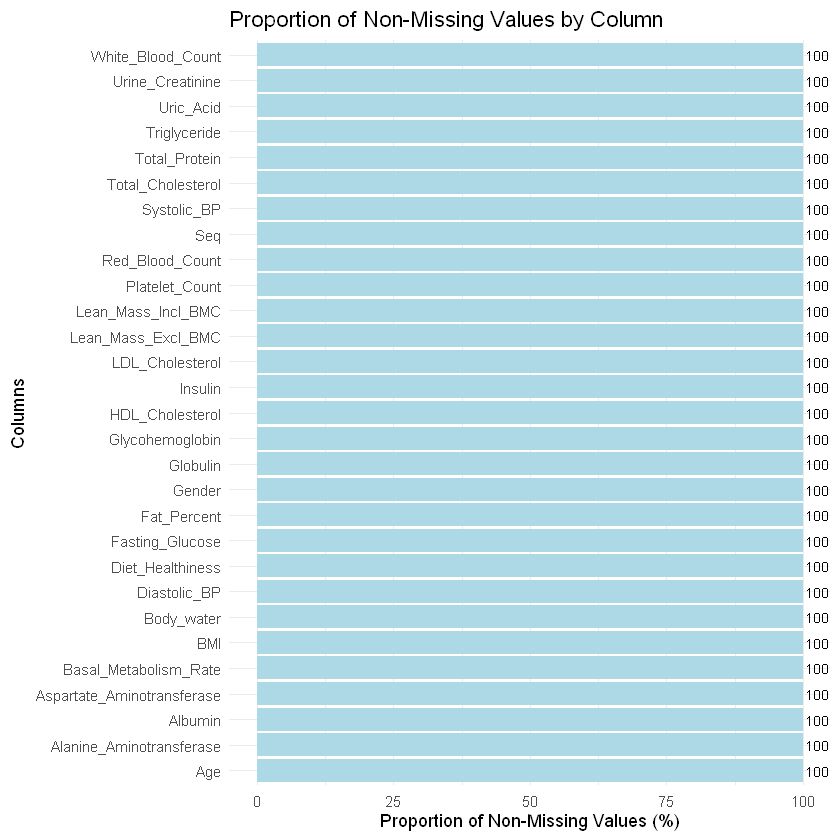

In [17]:
# Initialize an empty data frame to store the proportions
missing_value_proportion <- data.frame(Column = character(), Proportion = numeric(), stringsAsFactors = FALSE)

# Loop over each column index in the data
for (i in 1:ncol(complete_data)) {
    # Calculate the proportion of missing values for the column
    proportion <- round(100 - (sum(is.na(complete_data[, i])) / nrow(complete_data) * 100), 2)
    
    # Add the column name and proportion to the data frame
    missing_value_proportion <- rbind(missing_value_proportion, data.frame(Column = colnames(complete_data)[i], Proportion = proportion))
}

# Create bar plot
ggplot(missing_value_proportion, aes(x = reorder(Column, Proportion), y = Proportion)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  coord_flip() +
  geom_text(aes(label = round(Proportion, 2)), hjust = -0.1, size = 3) +
  labs(title = "Proportion of Non-Missing Values by Column",
       x = "Columns",
       y = "Proportion of Non-Missing Values (%)") +
       theme_minimal()

## **5. Target Variable Analysis** <a id = 5></a>

**BMI Classification:**
- Non-Obese (BMI < 25)
- Pre-Obese (25 ≤ BMI < 30)
- Obesity Class I (30 ≤ BMI < 35)
- Obesity Class II (35 ≤ BMI < 40)
- Obesity Class III (BMI ≥ 40)

<p style="text-align: justify;">
The code categorizes the BMI values into 5 classes and creates a new column for the obesity category.The code also removes the redundant "BMI" column from the dataset.
<p>

In [18]:
# Categorize BMI into groups and add a new column for obesity category and remove redundent features
complete_data <- complete_data %>% 
  mutate(
    Obesity_Category = cut(
        BMI,
        breaks = c(-Inf, 25, 30, 35, 40, Inf),
        labels = c("Non-Obese", "Pre-Obese", "Obesity Class I", "Obesity Class II", "Obesity Class III"),
        right = FALSE)
    ) %>% 
  dplyr::select(-c("BMI"))

<p style="text-align: justify;">
The code creates a frequency table for the "Obesity_Category" column, showing the proportion of each category as a percentage, rounded to two decimal places. This is important for checking that the response variable is balanced.<p>

In [19]:
# Create a frequency table for the Obesity_Category column
as.data.frame(round(prop.table(table(complete_data$Obesity_Category)) * 100, 2))

Var1,Freq
<fct>,<dbl>
Non-Obese,32.92
Pre-Obese,29.62
Obesity Class I,19.53
Obesity Class II,9.27
Obesity Class III,8.66


<p style="text-align: justify;">
The code creates a bar chart for the "Obesity_Category" factor variable, displaying the count of each category with labels. It also customizes the plot's title, axis labels, and text orientation, and uses a minimal theme for better visualization. This is useful for visually inspecting the distribution of the response variable.
<p>

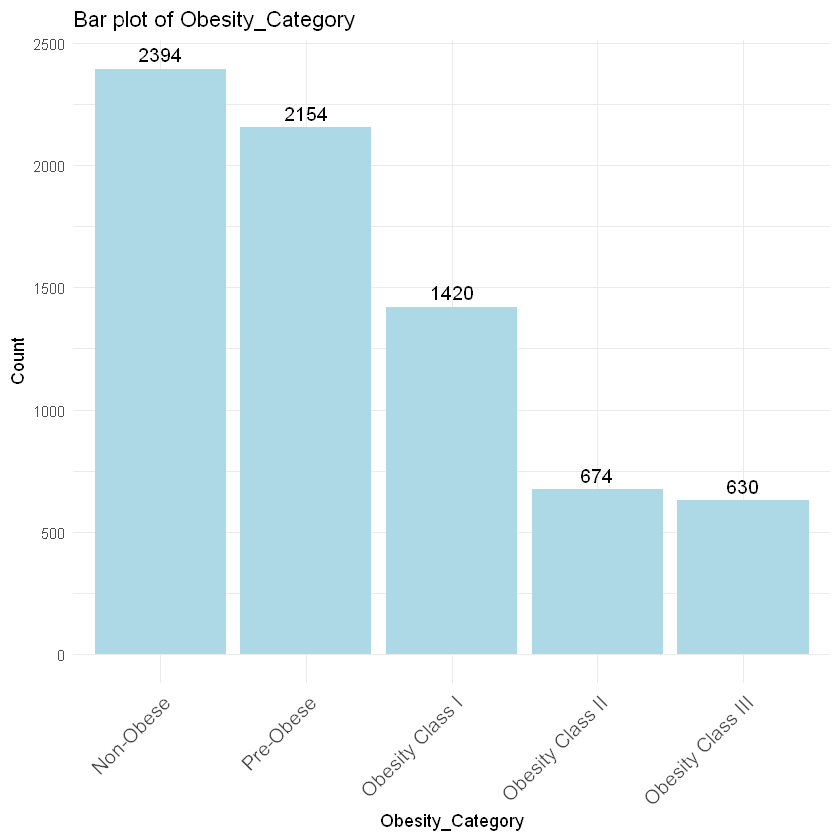

In [20]:
# Create Bar chart for a factor variable
plot <- ggplot(complete_data, aes(x = Obesity_Category)) + 
    geom_bar(position = "identity", fill = "lightblue") +
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.5, size = 4) +
    labs(title = paste("Bar plot of Obesity_Category"),
         x = "Obesity_Category",
         y = "Count") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1, size = 12)
    )
  
# Print the plot
print(plot)

## **6. Train and Test Splitting** <a id = 6></a>

<p style="text-align: justify;">
The code sets a seed for reproducibility, then splits the dataset into training and testing sets, with 70% of the data used for training and 30% for testing. It also removes the "Seq" column from both sets. Finally, the code checks and prints the dimensions of the training and testing datasets.
<p>

In [21]:
# Set a seed for reproducibility
set.seed(555)

# Split the data into training and testing sets
split <- sample.split(Y = complete_data$Obesity_Category, SplitRatio = 0.8)

# Create the training set
train_data <- subset(complete_data, split == TRUE)
train_data <- dplyr::select(train_data, - Seq)

# Create the testing set
test_data <- subset(complete_data, split == FALSE)
test_data <- dplyr::select(test_data, -Seq)

# Check test and train dimensions
cat("Train Data:", dim(train_data), "\n")
cat("Test Data:", dim(test_data), "\n")

Train Data: 5817 28 
Test Data: 1455 28 


<p style="text-align: justify;">
The code creates a frequency table for the "Obesity_Category" column in the training dataset, showing the proportion of each category as a percentage, rounded to two decimal places. This is useful for ensuring the distribution of the response variable in the training set.
<p>

In [22]:
# Create a frequency table for the Obesity_Category column
as.data.frame(round(prop.table(table(train_data$Obesity_Category)) * 100, 2))

Var1,Freq
<fct>,<dbl>
Non-Obese,32.92
Pre-Obese,29.62
Obesity Class I,19.53
Obesity Class II,9.27
Obesity Class III,8.66


In [23]:
# Create a copy of train_data to store normalized values
normalized_train_data <- train_data

# Save the normalized test_data to a separate variable for further use
normalized_test_data <- test_data

# Display the first few rows of the normalized train_data for verification
head(normalized_train_data)

# Display the first few rows of the normalized test_data for verification
head(normalized_test_data)

,Gender,Age,Diet_Healthiness,Fat_Percent,Lean_Mass_Excl_BMC,Lean_Mass_Incl_BMC,Diastolic_BP,Systolic_BP,Glycohemoglobin,Fasting_Glucose,⋯,Aspartate_Aminotransferase,Platelet_Count,Red_Blood_Count,White_Blood_Count,Albumin,Total_Protein,Globulin,Body_water,Basal_Metabolism_Rate,Obesity_Category
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Male,56,Very Good,22.8,42653.5,44395.50,68,108,5.7,107,⋯,23,264,4.65,5.0,4.0,7.1,3.1,36.52626,1421.113,Non-Obese
3,Male,45,Good,19.3,41062.2,50180.51,88,128,5.7,89,⋯,17,272,4.71,6.2,4.2,7.2,3.0,33.51505,1316.577,Non-Obese
4,Male,20,Fair,31.3,55439.3,57441.00,54,114,4.9,98,⋯,14,261,5.58,8.8,4.5,7.5,3.0,49.92830,2033.175,Pre-Obese
5,Male,52,Good,31.2,48342.4,50180.51,74,154,5.0,83,⋯,11,120,3.79,6.3,3.8,7.0,3.2,39.27388,1526.841,Obesity Class II
6,Male,26,Very Good,25.1,67209.8,69490.10,82,120,5.6,102,⋯,26,259,5.56,7.0,4.3,7.5,3.2,51.19552,2066.437,Obesity Class I
7,Female,26,Good,42.6,48026.4,50198.60,76,106,5.7,110,⋯,14,315,4.55,8.3,4.1,7.1,3.0,40.11573,1755.375,Pre-Obese


,Gender,Age,Diet_Healthiness,Fat_Percent,Lean_Mass_Excl_BMC,Lean_Mass_Incl_BMC,Diastolic_BP,Systolic_BP,Glycohemoglobin,Fasting_Glucose,⋯,Aspartate_Aminotransferase,Platelet_Count,Red_Blood_Count,White_Blood_Count,Albumin,Total_Protein,Globulin,Body_water,Basal_Metabolism_Rate,Obesity_Category
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,Male,22,Very Good,20.4,54434.5,56594.8,62,116,5.1,91,⋯,17,238,4.82,5.5,4.3,7.6,3.3,44.14672,1795.711,Non-Obese
10,Male,40,Fair,20.2,60575.5,62978.2,84,120,5.3,106,⋯,22,156,5.28,6.7,4.4,7.0,2.6,46.55652,1858.988,Pre-Obese
13,Male,55,Excellent,25.9,51482.3,53549.8,56,130,5.5,102,⋯,20,157,4.76,6.7,4.5,8.2,3.7,41.84329,1635.903,Pre-Obese
15,Female,47,Very Good,40.2,30875.5,32262.9,76,108,5.4,92,⋯,14,271,4.67,9.4,3.6,7.1,3.5,28.40686,1250.972,Pre-Obese
17,Female,46,Good,43.4,44091.3,45870.7,90,128,5.3,109,⋯,22,351,4.83,7.9,4.2,7.4,3.2,36.76623,1558.472,Obesity Class I
19,Female,21,Good,33.8,35089.0,36639.2,66,104,5.7,97,⋯,13,247,4.53,7.8,4.0,7.1,3.1,29.44695,1396.634,Non-Obese


## **7. Model Development** <a id = 7></a>

### ***7.1. Polytomous Logistic Regression*** <a id = 7-1></a>

<p style="text-align: justify;">
The code trains a polytomous logistic regression (PLR) model using the formula defined earlier, with the target variable "Obesity_Category" and the selected predictors from the normalized training dataset. After training the model, the code displays a summary of the model's results.
<p>

In [24]:
# Train a polytomous logistic regression model
PLR_model <- multinom(Obesity_Category ~ ., data = normalized_train_data)

# Display the summary of the trained model
summary(PLR_model)

# weights:  165 (128 variable)
initial  value 9362.100337 
iter  10 value 8206.463180
iter  20 value 7505.819046
iter  30 value 6607.250252
iter  40 value 6249.907977
iter  50 value 5937.697200
iter  60 value 5779.744834
iter  70 value 5740.202350
iter  80 value 5329.237364
iter  90 value 4460.997952
iter 100 value 4098.146387
final  value 4098.146387 
stopped after 100 iterations


Call:
multinom(formula = Obesity_Category ~ ., data = normalized_train_data)

Coefficients:
                  (Intercept) GenderMale        Age Diet_HealthinessExcellent
Pre-Obese           -1.484036 0.05630314 -0.1698259                -1.0271983
Obesity Class I     -4.493254 4.79634319 -0.2413519                -0.4736309
Obesity Class II    -8.450758 2.03281229 -0.3074351                -3.0969614
Obesity Class III  -11.758709 4.97829442 -0.3532067                -1.6519485
                  Diet_HealthinessFair Diet_HealthinessGood
Pre-Obese                   -0.3144858           -0.4637059
Obesity Class I              0.4900704           -0.1707522
Obesity Class II            -1.7239411           -2.3957715
Obesity Class III           -1.8282150           -1.8103367
                  Diet_HealthinessPoor Diet_HealthinessVery Good Fat_Percent
Pre-Obese                   -1.3218771                -1.0634127   0.4618635
Obesity Class I             -0.2434011                -0.7635574

### ***7.2. Decision Tree*** <a id = 7-2></a>

<p style="text-align: justify;">
The code sets up a 5-fold cross-validation with grid search for training the decision tree model. It creates a grid of complexity parameter (cp) values to tune the model, ranging from 0 to 0.3 with a very fine resolution. Then, it trains a decision tree model, performing cross-validation and grid search to find the optimal complexity parameter. This is important for optimizing the model's complexity, preventing over-fitting, and ensuring that the decision tree generalizes well to unseen data.
<p>

In [25]:
# Set up 5-fold cross-validation for training
set.seed(555)

folds <- createFolds(
      normalized_train_data$Obesity_Category,
      k = 5
      )

num_fold <- trainControl(
      method = "cv",
      number = 5,
      index = folds      # Fix the predefined folds
      )

# Create a grid of complexity parameter (cp) values for tuning
cp_grid <- expand.grid(.cp = seq(0, 0.3, 0.0001))

# Train a decision tree model using rpart with cross-validation and grid search
DT_crossValidation <- train(
      Obesity_Category ~ .,
      data = normalized_train_data,
      method = "rpart", 
      trControl = num_fold,
      tuneGrid = cp_grid
      )

DT_crossValidation

# Extract the optimal cp
optimal_cp <- DT_crossValidation$bestTune

# Print the optimal cp
cat("Optimal cp:", optimal_cp[1, 1], "\n")

CART 

5817 samples
  27 predictor
   5 classes: 'Non-Obese', 'Pre-Obese', 'Obesity Class I', 'Obesity Class II', 'Obesity Class III' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1164, 1164, 1161, 1164, 1164 
Resampling results across tuning parameters:

  cp      Accuracy   Kappa     
  0.0000  0.6393345  0.51645318
  0.0001  0.6393345  0.51645318
  0.0002  0.6393345  0.51645318
  0.0003  0.6393345  0.51645318
  0.0004  0.6393345  0.51645318
  0.0005  0.6403225  0.51781035
  0.0006  0.6403225  0.51781035
  0.0007  0.6406663  0.51834941
  0.0008  0.6406663  0.51834941
  0.0009  0.6406663  0.51834941
  0.0010  0.6406663  0.51834941
  0.0011  0.6406663  0.51834941
  0.0012  0.6406663  0.51834941
  0.0013  0.6569538  0.53996347
  0.0014  0.6569538  0.53996347
  0.0015  0.6569538  0.53996347
  0.0016  0.6569538  0.53996347
  0.0017  0.6569538  0.53996347
  0.0018  0.6585011  0.54216799
  0.0019  0.6585011  0.54216799
  0.0020  0.6572116  0.54023361
  0

Optimal cp: 0.0057 


<p style="text-align: justify;">
The code trains a decision tree model with the specified formula and a complexity parameter (cp) obtained from cross-validation. The model is trained using the "class" method, which is appropriate for classification tasks. After training, the model's structure is visualized, which displays the tree with custom branch colors for different outcomes (e.g., "no" and "yes"). This visualization helps to understand the decision-making process of the model and how it splits the data based on the features.
<p>

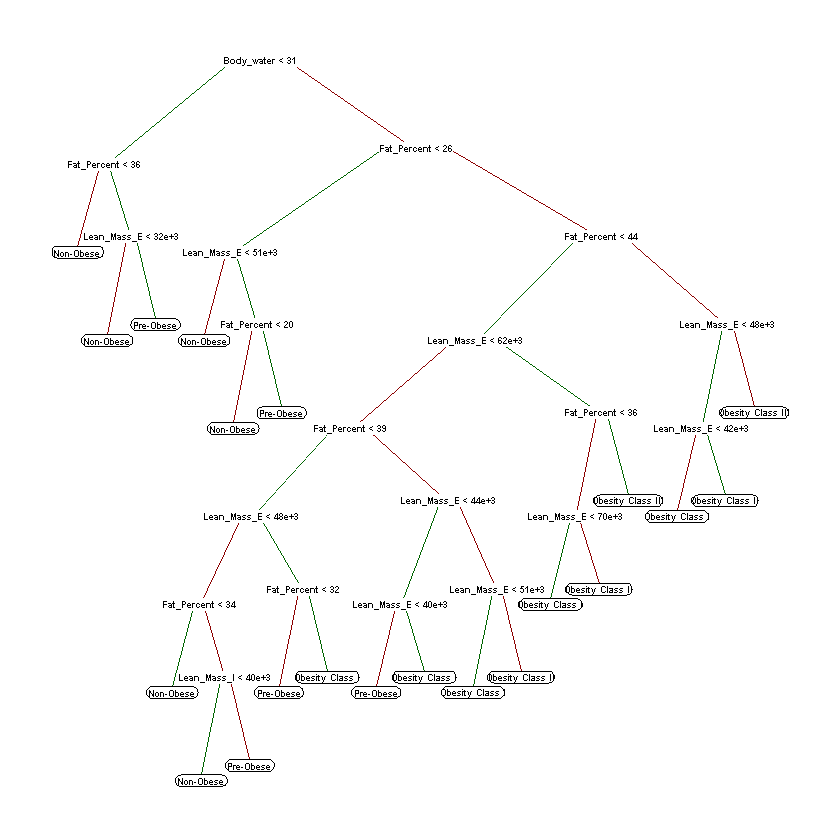

In [26]:
# Train a decision tree model
DT_model <- rpart(Obesity_Category ~ ., data = normalized_train_data, method = "class", cp = optimal_cp[1, 1])

# Display the summary of the trained model
par(bg = "white")
plot <- prp(
  DT_model,
  branch.col = c("darkred", "darkgreen"),  # Custom branch colors for "no" and "yes"
  yesno = FALSE # Remove "yes" and "no" from the nodes
)

# Display the decision tree plot
options(repr.plot.width = 12, repr.plot.height = 10)

<p style="text-align: justify;">
The code trains a decision tree model, predicting the "Obesity_Category" from the entire set of features in the `normalized_train_data`. It then extracts the feature importance from the trained decision tree model. Then, the code creates a horizontal bar plot to visualize the importance of each feature in the model. The plot displays each feature's importance value, helping to understand which variables contribute most to predicting the target variable. This is useful for feature selection and understanding the model's decision-making process.
<p>

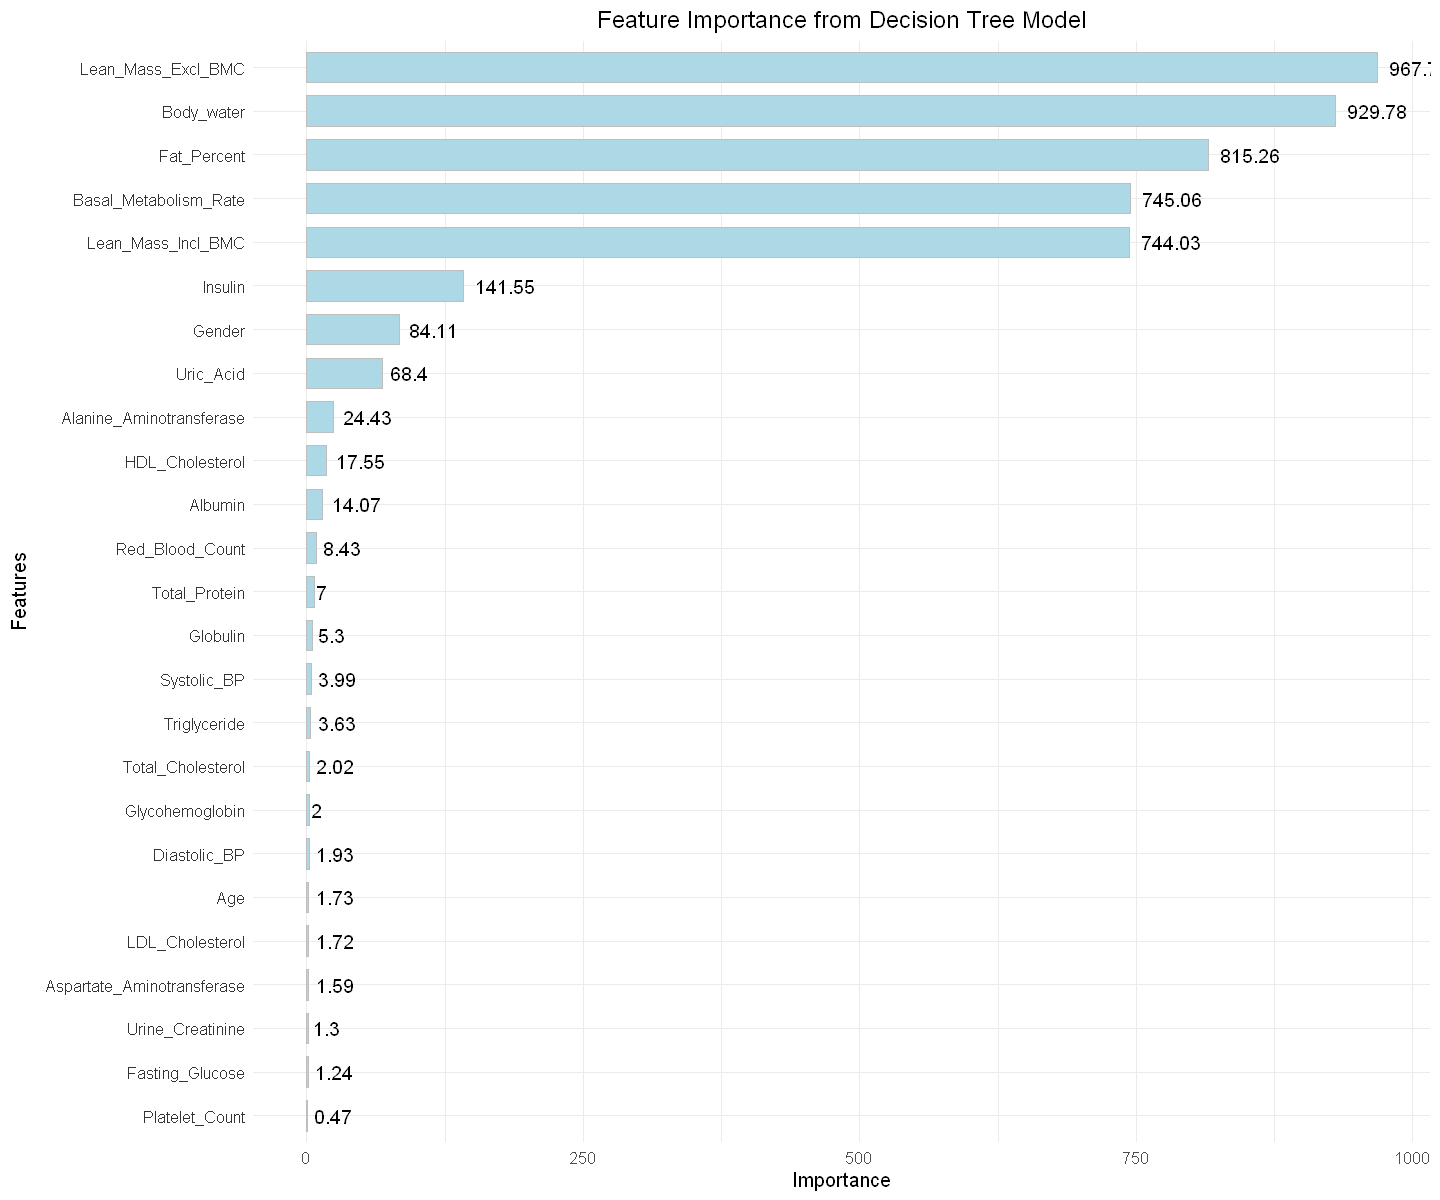

In [27]:
# Train a decision tree model
DT_model_FS <- rpart(Obesity_Category ~ ., data = normalized_train_data, method = "class", cp = optimal_cp[1, 1])

# Extract feature importance
feature_importance <- DT_model_FS$variable.importance

# Create a data frame for plotting
feature_importance_df <- data.frame(
  Feature = names(feature_importance),
  Importance = feature_importance
)

# Sort features by importance
feature_importance_df <- feature_importance_df[order(feature_importance_df$Importance, decreasing = TRUE), ]

# Plot the feature importance with ggplot2
ggplot(feature_importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = 'identity', fill = "lightblue", color = "gray", width = 0.7) +
  geom_text(aes(label = round(Importance, 2)), hjust = -0.2, size = 4, color = "black") +
  coord_flip() +  # Flip coordinates for horizontal bars
  labs(
    x = "Features",
    y = "Importance",
    title = "Feature Importance from Decision Tree Model"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(hjust = 0.5),
    axis.text.y = element_text(color = "#333333"),
    axis.text.x = element_text(size = 10)
  )

### ***7.3. Random Forest*** <a id = 7-3></a>

<p style="text-align: justify;">
The code sets up a 5-fold cross-validation for training a random forest model. It creates a grid of "mtry" values (the number of variables randomly sampled at each split) to tune the model, ranging from 2 to the number of features minus one. This is important for optimizing the random forest model's parameters and ensuring it performs well on the data.
<p>

In [28]:
# Set up 5-fold cross-validation for training
set.seed(555)
folds <- createFolds(normalized_train_data$Obesity_Category, k = 5)

# Cross-validation setup
num_fold <- trainControl(
      method = "cv",
      number = 5,
      index = folds  # Fix predefined folds
)

# Adjust the mtry grid dynamically
mtry_grid <- expand.grid(.mtry = seq(1, ncol(normalized_train_data) - 1, by = 1)) # Ensure valid range for mtry

# Train a random forest model using caret with cross-validation and grid search
RF_crossValidation <- train(
      Obesity_Category ~ .,
      data = normalized_train_data,
      method = "rf", 
      trControl = num_fold,
      tuneGrid = mtry_grid
)

# Print model results
print(RF_crossValidation)

# Extract the optimal mtry
optimal_mtry <- RF_crossValidation$bestTune
cat("Optimal mtry:", optimal_mtry[1, 1], "\n")

Random Forest 

5817 samples
  27 predictor
   5 classes: 'Non-Obese', 'Pre-Obese', 'Obesity Class I', 'Obesity Class II', 'Obesity Class III' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1164, 1164, 1161, 1164, 1164 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   1    0.5682907  0.3955194
   2    0.6590158  0.5353208
   3    0.6758630  0.5605768
   4    0.6852326  0.5743760
   5    0.6914648  0.5835983
   6    0.6946872  0.5882965
   7    0.6987274  0.5940429
   8    0.6982977  0.5936662
   9    0.7016929  0.5984620
  10    0.7021228  0.5991111
  11    0.7019082  0.5988629
  12    0.7039713  0.6018953
  13    0.7031116  0.6008283
  14    0.7040571  0.6021295
  15    0.7022950  0.5997734
  16    0.7025960  0.6001139
  17    0.7029827  0.6007274
  18    0.7039279  0.6019451
  19    0.7053031  0.6039303
  20    0.7031546  0.6010741
  21    0.7045726  0.6029975
  22    0.7051743  0.6039064
  23    0.7053892  0.6042269
  

<p style="text-align: justify;">
The code trains a random forest model with the specified formula and several hyper-parameters. After training the model, the code displays a summary of the trained random forest model, which includes information about the model's performance, error rate, and feature importance. This is useful for assessing the model's predictive power and understanding which features contribute most to the model's decision-making process.
<p>

In [29]:
# Train a random forest model
RF_model <- randomForest(
   Obesity_Category ~ .,
   data = normalized_train_data,
   mtry = optimal_mtry[1, 1],
   ntree = 500,
   nodesize = 30,
   importance = TRUE
   )

# Display the summary of the trained model
RF_model


Call:
 randomForest(formula = Obesity_Category ~ ., data = normalized_train_data,      mtry = optimal_mtry[1, 1], ntree = 500, nodesize = 30, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 23

        OOB estimate of  error rate: 25.51%
Confusion matrix:
                  Non-Obese Pre-Obese Obesity Class I Obesity Class II
Non-Obese              1664       249               2                0
Pre-Obese               243      1287             188                5
Obesity Class I           3       316             705              107
Obesity Class II          0        10             186              265
Obesity Class III         0         0               7               85
                  Obesity Class III class.error
Non-Obese                         0   0.1310705
Pre-Obese                         0   0.2530470
Obesity Class I                   5   0.3794014
Obesity Class II    

<p style="text-align: justify;">
The code trains a random forest model, predicting the "Obesity_Category" from the entire set of features in the `normalized_train_data`. It then extracts the feature importance from the trained random forest model. Then, the code creates a horizontal bar plot to visualize the importance of each feature in the model. The plot displays each feature's importance value, helping to understand which variables contribute most to predicting the target variable. This is useful for feature selection and understanding the model's decision-making process.
<p>

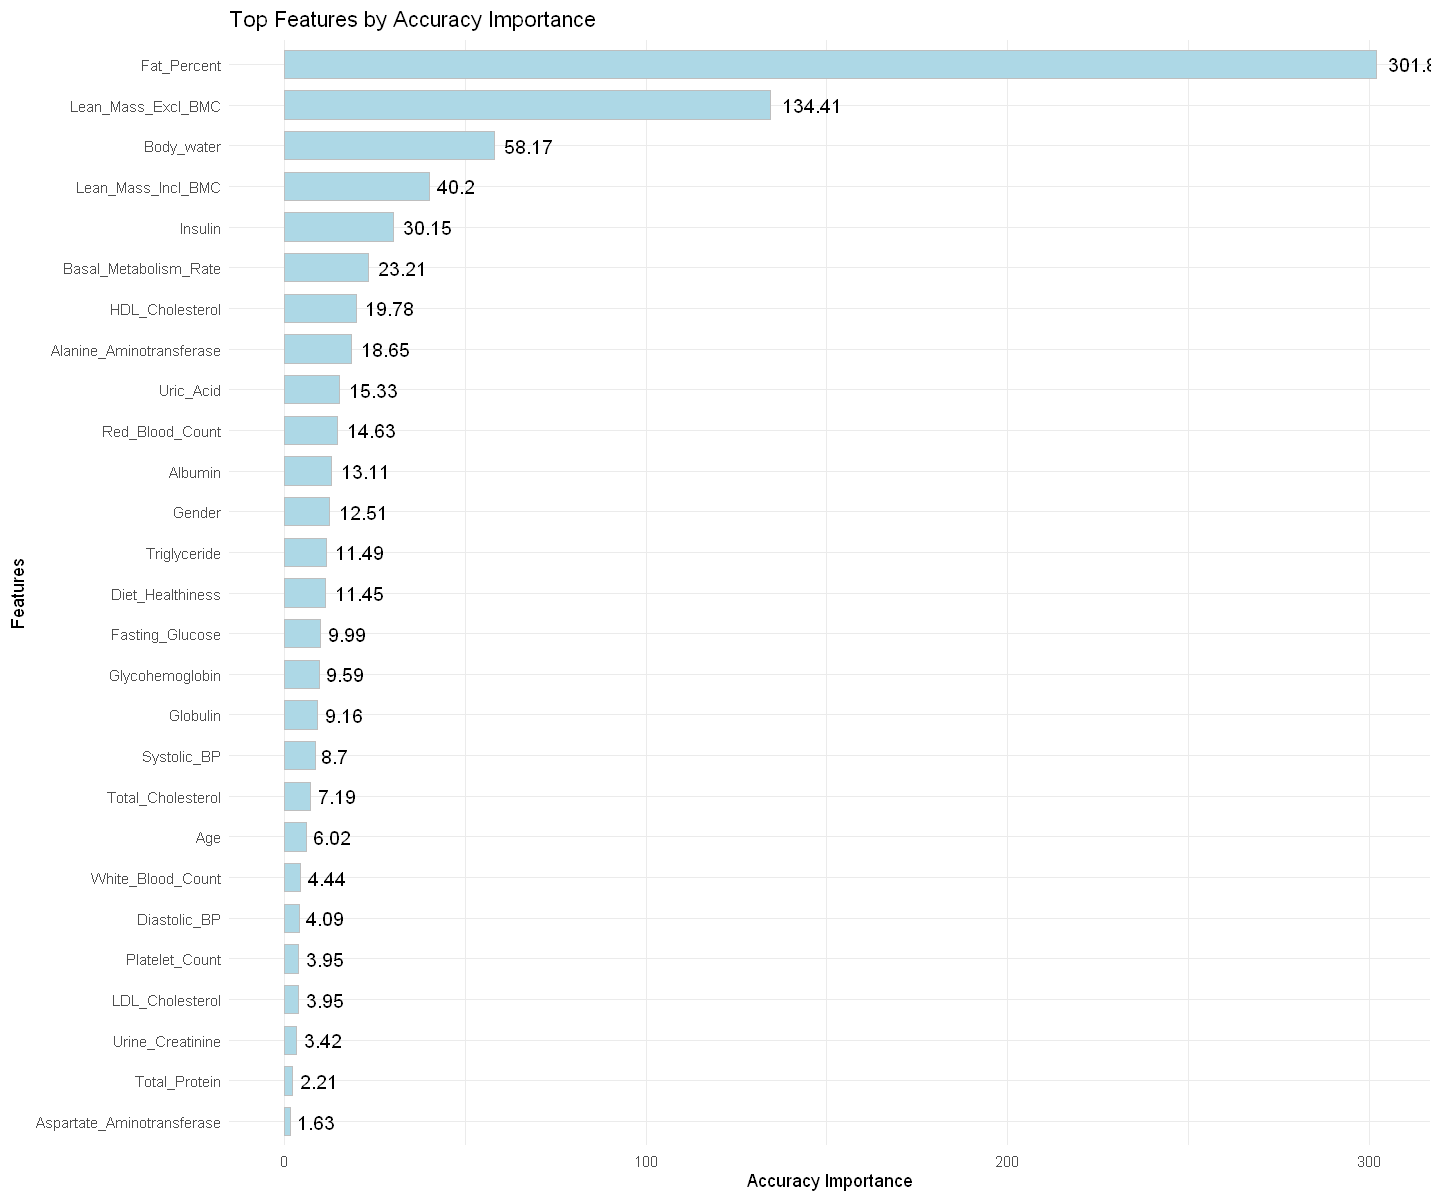

In [30]:
# Train a random forest model
RF_model_FS <- randomForest(
   Obesity_Category ~ .,
   data = normalized_train_data,
   mtry = optimal_mtry[1, 1],
   ntree = 500,
   nodesize = 30,
   importance = TRUE
   )

# Extract feature importance and create a dataframe
feature_importance_df <- importance(RF_model_FS) %>% 
  data.frame() %>% 
  mutate(Feature = row.names(.))  # Rename the column to a more descriptive name

# Plot the feature importance with values displayed on the bars
ggplot(feature_importance_df, aes(x = reorder(Feature, MeanDecreaseAccuracy), 
                                  y = MeanDecreaseAccuracy)) +
  geom_bar(stat = 'identity', fill = "lightblue", color = "gray", width = 0.7) +  # Horizontal bars
  geom_text(aes(label = round(MeanDecreaseAccuracy, 2)),    # Add rounded importance values
            hjust = -0.2, size = 4, color = "black") +  # Position text slightly outside the bars
  coord_flip() +  # Flip the coordinates for horizontal bars
  labs(
    x     = "Features",                        # Make axis label plural for clarity
    y     = "Accuracy Importance",                 # Be more specific about the importance type
    title = "Top Features by Accuracy Importance"  # Add a descriptive title
  ) +
  theme(
    text = element_text(size = 12),         # Increase font size for readability
    plot.title = element_text(hjust = 0.5), # Center-align the title
    axis.text.y = element_text(color = "#333333"),  # Improve axis text color
    axis.text.x = element_text(size = 10)   # Increase x-axis label text size
  ) + 
  theme_minimal()

### ***7.4. Support Vector Machine*** <a id = 7-4></a>

<p style="text-align: justify;">
The code trains a Support Vector Machine (SVM) model with a radial basis function (RBF) kernel to predict "Obesity_Category". It begins by setting up 5-fold cross-validation, ensuring reproducibility with a fixed random seed. A grid search is defined to tune the hyper-parameters (C: regularization parameter and gamma: kernel coefficient) by exploring values. Using the caret package, the train function performs cross-validation over the defined grid to identify the optimal combination of C and gamma that minimizes prediction error. Finally, the best hyper-parameters are extracted and displayed for use in the final SVM model.
</p>

In [57]:
# Set up 5-fold cross-validation
set.seed(555)
folds <- createFolds(normalized_train_data$Obesity_Category, k = 5)

# Cross-validation control
svm_trControl <- trainControl(
  method = "cv",
  number = 5,
  index = folds  # Fix predefined folds
)

# Define a grid for C and gamma
svm_grid <- expand.grid(
  .C = 2^(-5:5),          # Explore C values from 2^-5 to 2^5
  .sigma = 2^(-5:5)       # Explore sigma (gamma) values from 2^-5 to 2^5
)

# Train SVM model using caret
SVM_crossValidation <- train(
  Obesity_Category ~ .,
  data = normalized_train_data,
  method = "svmRadial",    # Radial basis function kernel
  trControl = svm_trControl,
  tuneGrid = svm_grid
)

# Print model results
print(SVM_crossValidation)

# Extract optimal C and gamma
optimal_params <- SVM_crossValidation$bestTune
cat("Optimal C:", optimal_params$C, "\n")
cat("Optimal Gamma:", optimal_params$sigma, "\n")

Support Vector Machines with Radial Basis Function Kernel 

5817 samples
  27 predictor
   5 classes: 'Non-Obese', 'Pre-Obese', 'Obesity Class I', 'Obesity Class II', 'Obesity Class III' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1164, 1164, 1161, 1164, 1164 
Resampling results across tuning parameters:

  C         sigma     Accuracy   Kappa        
   0.03125   0.03125  0.3934173   1.061187e-01
   0.03125   0.06250  0.3295514   5.677258e-04
   0.03125   0.12500  0.3292075   0.000000e+00
   0.03125   0.25000  0.3292075   0.000000e+00
   0.03125   0.50000  0.3292075   0.000000e+00
   0.03125   1.00000  0.3292075   0.000000e+00
   0.03125   2.00000  0.3292075   0.000000e+00
   0.03125   4.00000  0.3292075   0.000000e+00
   0.03125   8.00000  0.3292075   0.000000e+00
   0.03125  16.00000  0.3292075   0.000000e+00
   0.03125  32.00000  0.3292075   0.000000e+00
   0.06250   0.03125  0.4632980   2.222697e-01
   0.06250   0.06250  0.4205800   1.498882e

<p style="text-align: justify;">
The code trains the final Support Vector Machine (SVM) model using the optimal hyper-parameters obtained from the cross-validation process. The `svm` function from the `e1071` package is used, specifying the radial basis function (RBF) kernel for non-linear decision boundaries. The `cost` parameter is set to the optimal **C**, which controls the trade-off between achieving a low training error and model complexity, while the `gamma` parameter is set to the optimal value, determining the influence of each training point on the decision boundary. The `cross = 5` argument performs a 5-fold cross-validation to validate the model's performance. Finally, the `summary` function outputs detailed information about the trained model, including the number of support vectors, cross-validation accuracy, and kernel parameters.
</p>

In [132]:
# Train the final SVM model with the optimal parameters
SVM_model <- svm(
  Obesity_Category ~ .,
  data = normalized_train_data,
  kernel = "radial",
  cost = optimal_params$C,
  gamma = optimal_params$sigma,
  cross = 5,  # Perform 5-fold cross-validation
  probability = TRUE  # Enable probability predictions

)

# Display the summary of the final SVM model
summary(SVM_model)


Call:
svm(formula = Obesity_Category ~ ., data = normalized_train_data, 
    kernel = "radial", cost = optimal_params$C, gamma = optimal_params$sigma, 
    cross = 5, probability = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  2 

Number of Support Vectors:  4132

 ( 783 1427 539 1075 308 )


Number of Classes:  5 

Levels: 
 Non-Obese Pre-Obese Obesity Class I Obesity Class II Obesity Class III

5-fold cross-validation on training data:

Total Accuracy: 72.03026 
Single Accuracies:
 71.36715 73.00086 72.33677 71.28117 72.16495 




### ***7.5. K-Nearest Neighbors*** <a id = 7-5></a>

<p style="text-align: justify;">
The code trains a K-Nearest Neighbors (KNN) model using 5-fold cross-validation to identify the optimal number of neighbors. A grid search tests values of `k` from 1 to 100, and the `train` function evaluates each value to find the one that achieves the highest accuracy. The best `k` is then extracted for use in the final model. This process ensures the model is fine-tuned for the dataset, balancing accuracy and generalization.
</p>

In [121]:
# Set up 5-fold cross-validation
set.seed(555)
folds <- createFolds(normalized_train_data$Obesity_Category, k = 5)

# Cross-validation control
knn_trControl <- trainControl(
  method = "cv",
  number = 5,           # Perform 5-fold cross-validation
  index = folds         # Fix predefined folds
)

# Define a grid for k (number of neighbors)
knn_grid <- expand.grid(
  .k = seq(1, 100, by = 1)  # Explore odd k values
)

# Train KNN model using caret
KNN_crossValidation <- train(
  Obesity_Category ~ .,
  data = normalized_train_data,
  method = "knn",             # KNN algorithm
  trControl = knn_trControl,  # Cross-validation control
  tuneGrid = knn_grid         # Grid of k values
)

# Print model results
print(KNN_crossValidation)

# Extract the optimal k
optimal_k <- KNN_crossValidation$bestTune$k
cat("Optimal k:", optimal_k, "\n")

k-Nearest Neighbors 

5817 samples
  27 predictor
   5 classes: 'Non-Obese', 'Pre-Obese', 'Obesity Class I', 'Obesity Class II', 'Obesity Class III' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1164, 1164, 1161, 1164, 1164 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.3972842  0.1943232
    2  0.3891183  0.1844483
    3  0.4048052  0.1993885
    4  0.4145611  0.2077853
    5  0.4129283  0.2037413
    6  0.4162378  0.2057389
    7  0.4209657  0.2099917
    8  0.4236302  0.2121508
    9  0.4244475  0.2116548
   10  0.4280141  0.2154082
   11  0.4270259  0.2130861
   12  0.4289168  0.2141060
   13  0.4294749  0.2139129
   14  0.4283577  0.2111835
   15  0.4295610  0.2122889
   16  0.4309795  0.2135037
   17  0.4334300  0.2159433
   18  0.4353206  0.2182898
   19  0.4341604  0.2160015
   20  0.4351489  0.2167035
   21  0.4353636  0.2163972
   22  0.4370400  0.2182993
   23  0.4377702  0.2187577
   24  0.4384151  0.

<p style="text-align: justify;">
The code trains the final K-Nearest Neighbors (KNN) model using the optimal value of k identified during cross-validation. The `knn3` function is used to fit the model to the training dataset, where `Obesity_Category` is the target variable. The optimal number of neighbors (k) ensures the model achieves the best balance between accuracy and generalization. Finally, the trained model is printed, providing details about its configuration and structure.
</p>

In [122]:
# Train the final KNN model with the optimal k
KNN_model <- knn3(
  Obesity_Category ~ ., 
  data = normalized_train_data, 
  k = optimal_k
  )

# Display the summary of the final KNN model
print(KNN_model)

49-nearest neighbor model
Training set outcome distribution:

        Non-Obese         Pre-Obese   Obesity Class I  Obesity Class II 
             1915              1723              1136               539 
Obesity Class III 
              504 



## **8. Performance Comparison** <a id = 8></a>

### ***8.1. Train Data*** <a id = 8-1></a>

<p style="text-align: justify;">
The code generates predictions using the trained models, then creates a confusion matrix to compare the predicted and actual values of the "Obesity_Category" variable. From the confusion matrix, the code extracts counts for true positives, false positives, and false negatives for each class. Then, the code calculates Precision, Recall, and F1-scores for each class, then computes their averages (macro-averaged Precision, Recall, and F1-score). Finally, it calculates and displays the overall accuracy of the model. This is important for evaluating the model's performance in terms of correctly predicting the categories and assessing how well it generalizes to the test data.
<p>

In [68]:
# List of models to evaluate
models <- list(polytomousLogisticRegression = PLR_model, DecisionTree = DT_model, RandomForest = RF_model, SupportVectorMachine = SVM_model, KNearestNeighbors = KNN_model)

# Initialize a list to store results
results <- list()

# Iterate through each model and calculate metrics
for (model_name in names(models)) {
  cat("Evaluating model:", model_name, "\n")
  cat("--------------------------------------------------------------------\n\n")
  
  # Generate predictions for the test data
  predictions <- predict(models[[model_name]], newdata = normalized_train_data, type = "class")
  
  # Confusion matrix
  conf_matrix <- table(predictions, normalized_train_data$Obesity_Category)
  print(conf_matrix)
  
    # Confusion Matrix
    # ------------------------------------------------
    # Predicted/Actual   | Actual: Class A | Actual: Class B | Actual: Class C |
    # -------------------|-----------------|-----------------|-----------------|
    # Predicted: Class A | TP for Class A  | FP for Class B  | FP for Class C  |
    # Predicted: Class B | FN for Class A  | TP for Class B  | FP for Class C  |
    # Predicted: Class C | FN for Class A  | FN for Class B  | TP for Class C  |
    # ------------------------------------------------

  # Extract true positive, false positive, false negative counts
  true_positive <- diag(conf_matrix)                     # Diagonal values are true positives
  false_positive <- colSums(conf_matrix) - true_positive # Column sum minus true positives
  false_negative <- rowSums(conf_matrix) - true_positive # Row sum minus true positives
  
  # Precision, Recall, and F1-Score by Class
  precision <- true_positive / (true_positive + false_positive)
  recall <- true_positive / (true_positive + false_negative)
  
  # Handle NA values
  precision[is.na(precision)] <- 0
  recall[is.na(recall)] <- 0
  
  # F1-Scores
  f1_score <- 2 * (precision * recall) / (precision + recall)
  f1_score[is.na(f1_score)] <- 0
  
  # Macro-Averaged Precision, Recall, and F1-Score
  average_precision <- mean(precision)
  average_recall <- mean(recall)
  macro_f1 <- mean(f1_score)
  
  # Overall Accuracy
  accuracy <- sum(true_positive) / sum(conf_matrix)
  
  # Display results
  cat("\nPrecision by Class:\n")
  print(round(precision, 5))
  
  cat("Recall by Class:\n")
  print(round(recall, 5))
  
  cat("F1-Scores by Class:\n")
  print(round(f1_score, 5))
    
  # Display macro-averaged metrics and accuracy
  cat(paste("\nMacro-Averaged Precision:", round(average_precision, 5)), "\n")
  cat(paste("Macro-Averaged Recall:", round(average_recall, 5)), "\n")
  cat(paste("Macro-Averaged F1-Score:", round(macro_f1, 5)), "\n")
  cat(paste("Accuracy:", round(accuracy, 5)), "\n\n")
  
  # Save results to the list
  results[[model_name]] <- list(
    Macro_Precision = average_precision,
    Macro_Recall = average_recall,
    Macro_F1 = macro_f1,
    Accuracy = accuracy
  )
}

Evaluating model: polytomousLogisticRegression 
--------------------------------------------------------------------

                   
predictions         Non-Obese Pre-Obese Obesity Class I Obesity Class II
  Non-Obese              1724       302              10                2
  Pre-Obese               188      1215             310                6
  Obesity Class I           3       191             660              240
  Obesity Class II          0        11              94              141
  Obesity Class III         0         4              62              150
                   
predictions         Obesity Class III
  Non-Obese                         2
  Pre-Obese                         0
  Obesity Class I                  41
  Obesity Class II                 64
  Obesity Class III               397

Precision by Class:
        Non-Obese         Pre-Obese   Obesity Class I  Obesity Class II 
          0.90026           0.70517           0.58099           0.26160 
Obesity C

<p style="text-align: justify;">
The code creates a heatmap to visualize the confusion matrices, with color intensity representing the count of observations in each cell. This visualization is important for understanding the distribution of correct and incorrect classifications in the model's predictions, providing an intuitive view of its performance.
<p>

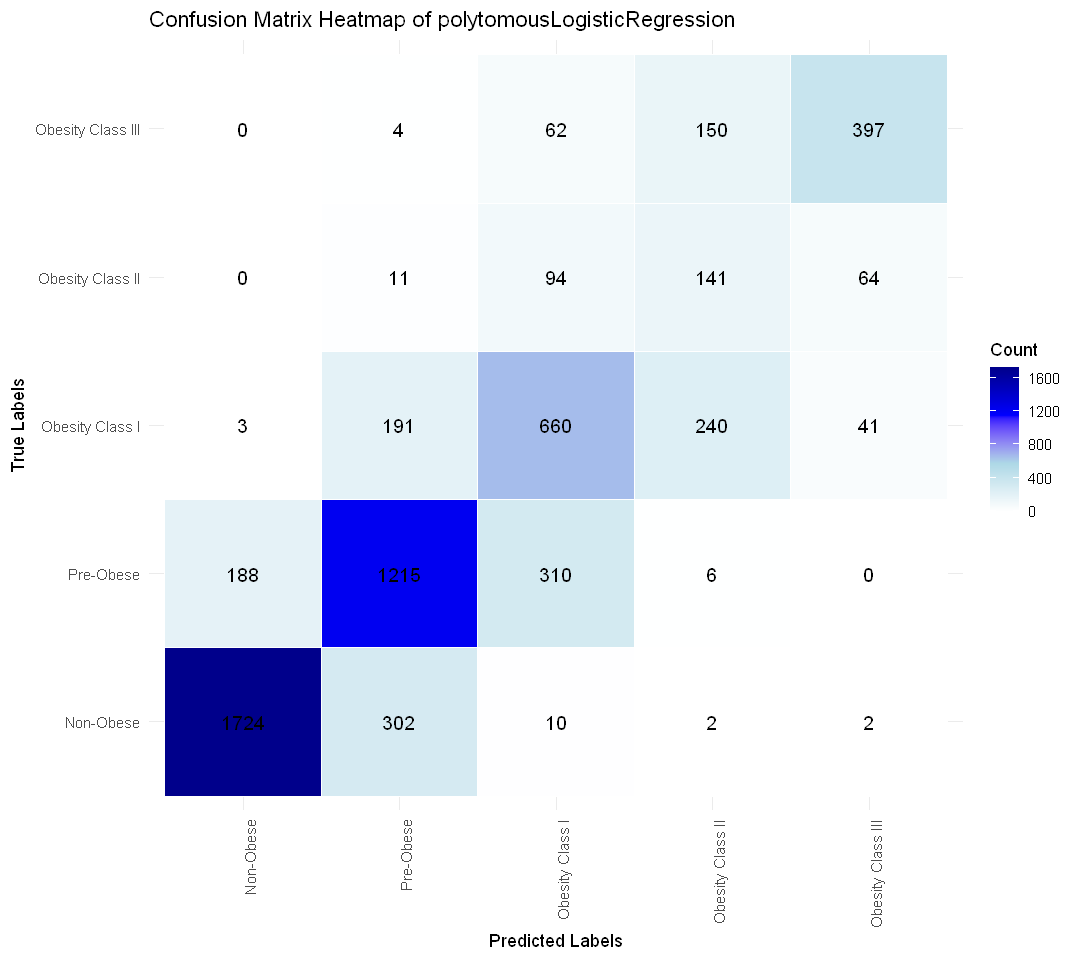

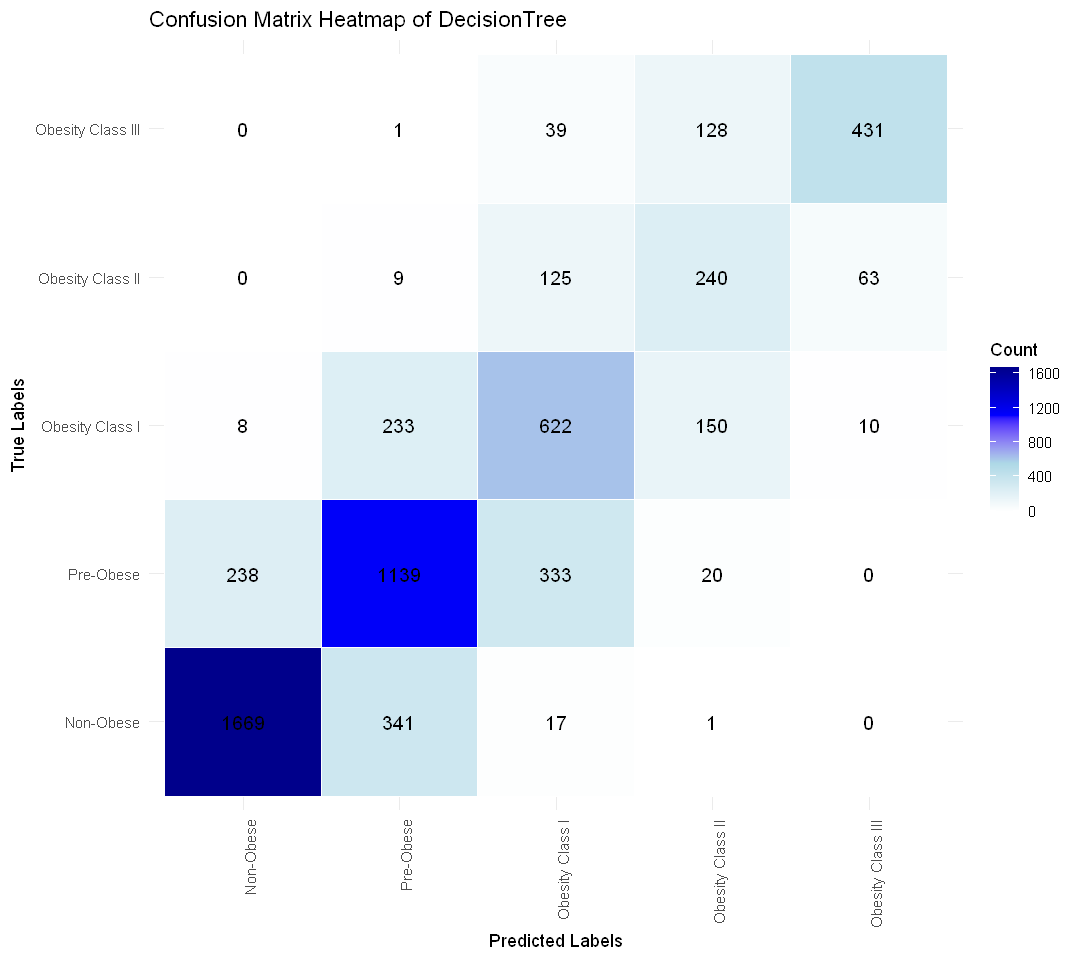

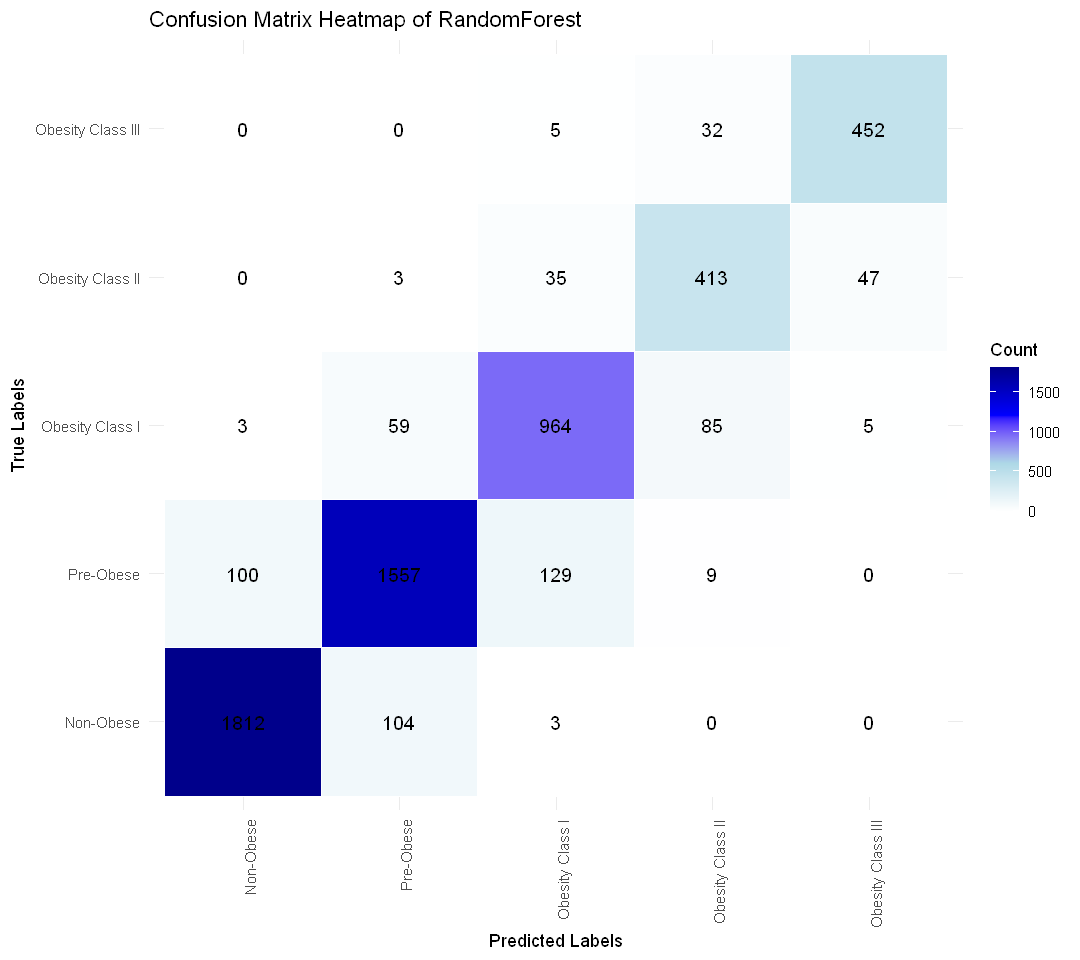

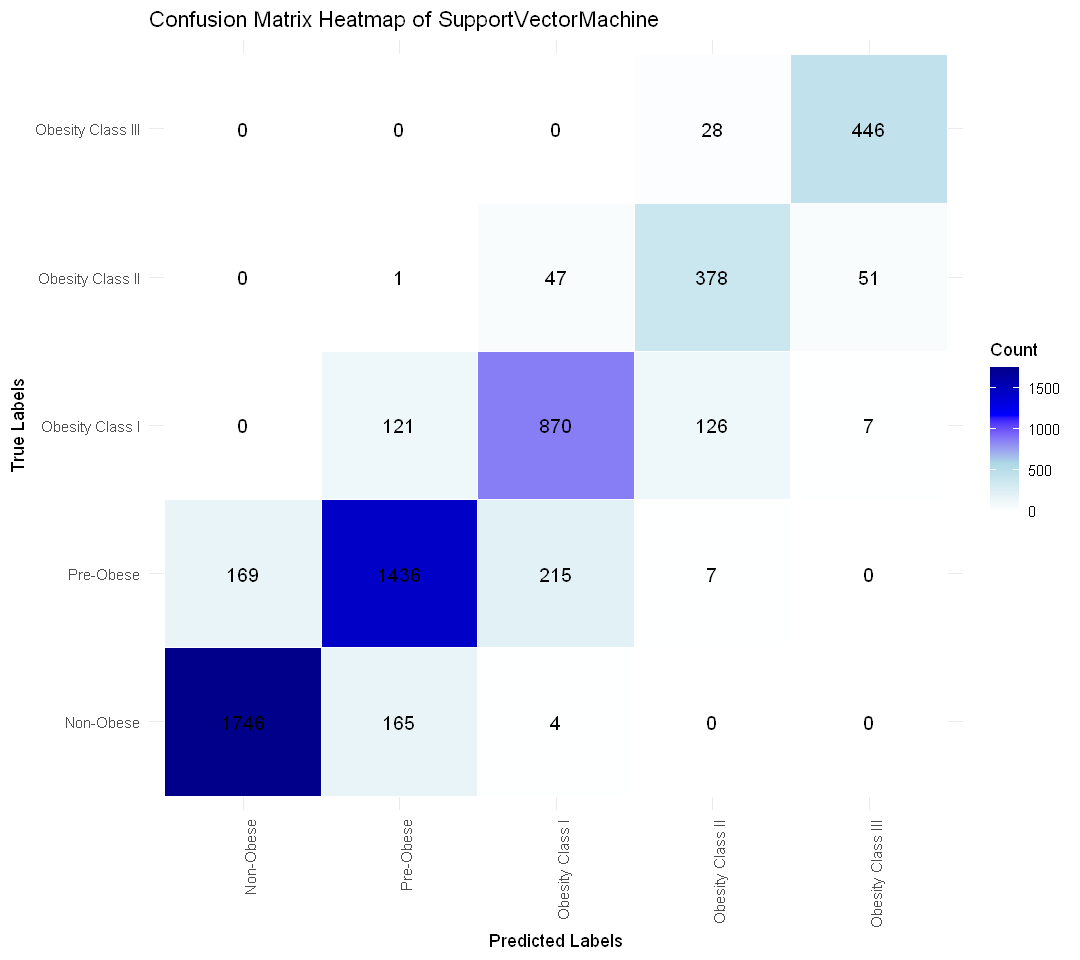

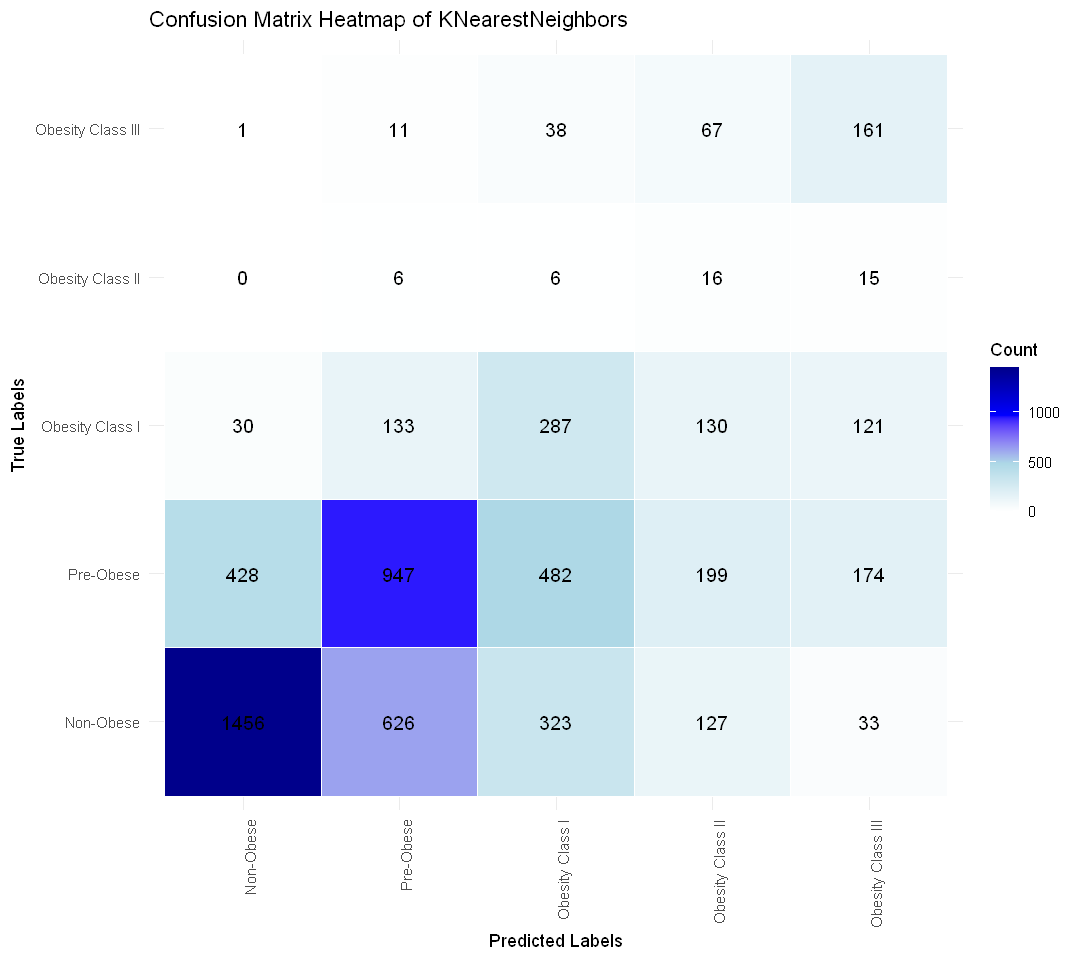

In [69]:
# List of models
models <- list(polytomousLogisticRegression = PLR_model, DecisionTree = DT_model, RandomForest = RF_model, SupportVectorMachine = SVM_model, KNearestNeighbors = KNN_model)

# Define class labels for rows and columns
class_labels <- c("Non-Obese", "Pre-Obese", "Obesity Class I", "Obesity Class II", "Obesity Class III")

# Loop through models
for (model_name in names(models)) {  
  # Generate predictions
  predictions <- predict(models[[model_name]], newdata = normalized_train_data, type = "class")
  
  # Confusion matrix
  conf_matrix <- table(predictions, normalized_train_data$Obesity_Category)
  
  # Add row and column names (class labels)
  rownames(conf_matrix) <- class_labels
  colnames(conf_matrix) <- class_labels
  
  # Convert matrix to a dataframe for ggplot
  conf_df <- as.data.frame(as.table(as.matrix(conf_matrix)))
  
  # Rename columns for compatibility with ggplot
  colnames(conf_df) <- c("True Labels", "Predicted Labels", "Count")
  
  # Plot heatmap using ggplot
  plot <- ggplot(data = conf_df, aes(x = `Predicted Labels`, y = `True Labels`, fill = Count)) +
    geom_tile(color = "white") +
    scale_fill_gradientn(colors = c("white", "lightblue", "blue", "darkblue")) +
    geom_text(aes(label = Count), color = "black", size = 4) +
    labs(title = paste("Confusion Matrix Heatmap of", model_name),
         x = "Predicted Labels",
         y = "True Labels",
         fill = "Count") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
  
  # Adjust the size of the displayed plot
  options(repr.plot.width = 9, repr.plot.height = 8)
  print(plot)
}

<p style="text-align: justify;">
The code generates predictions using the trained models, specifically predicting probabilities for each class. It then calculates the ROC (Receiver Operating Characteristic) curve and AUC (Area Under the Curve) for each class by iterating over the classes, extracting true labels and predicted probabilities, and plotting the ROC curves.<br>
The AUC for each class is calculated and displayed, and the macro-averaged AUC (the average of all class AUC values) is computed to evaluate the overall performance of the model. The plot shows the ROC curves for all classes in different colors, with a legend indicating the corresponding classes. This is important for assessing the model's discriminatory ability and how well it distinguishes between different categories, with the AUC serving as a key metric for classification performance.
<p>

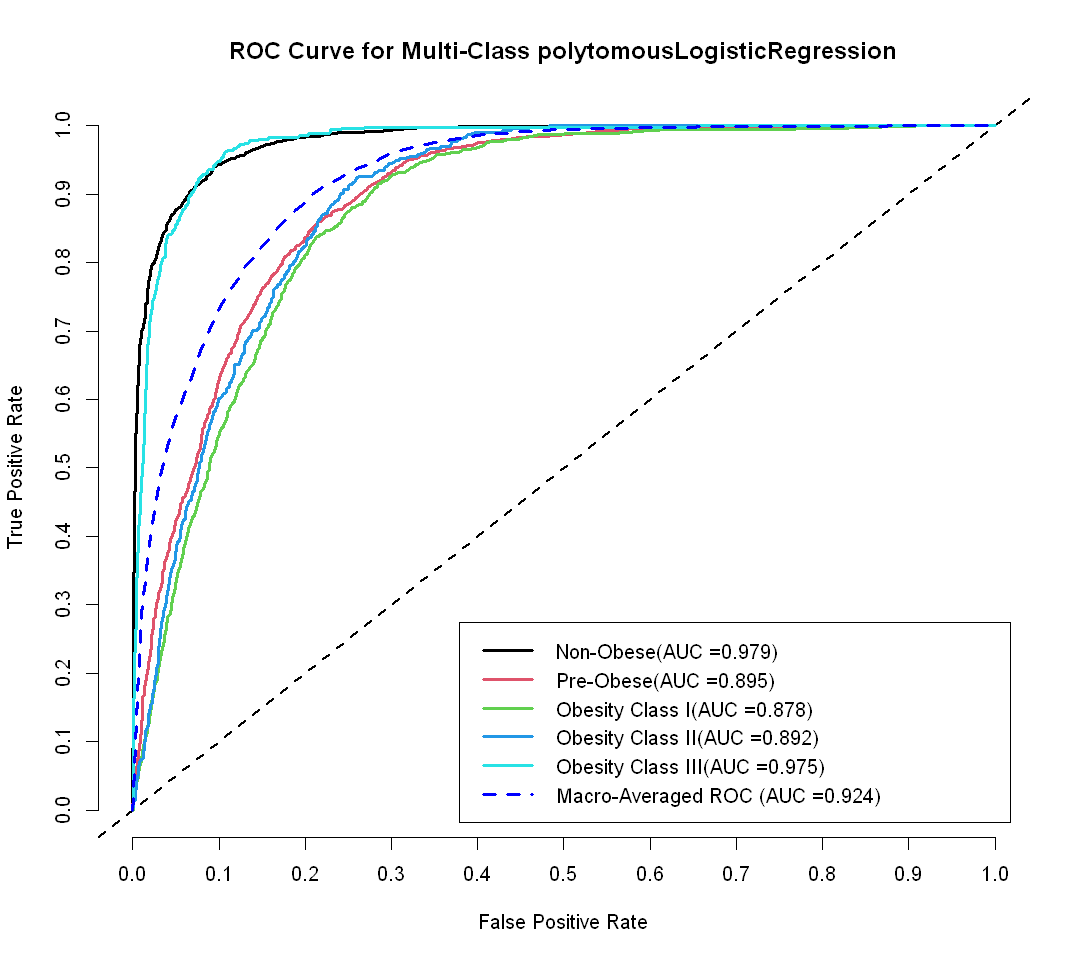

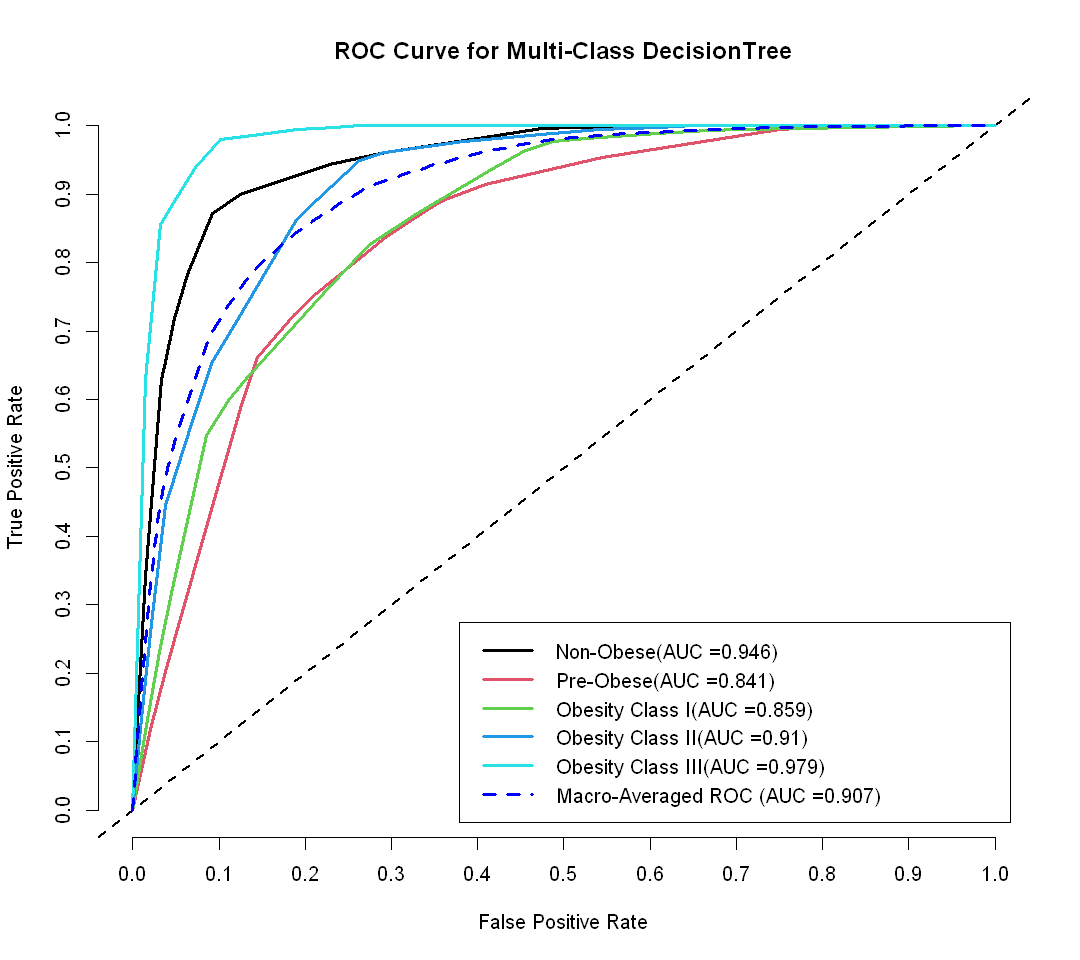

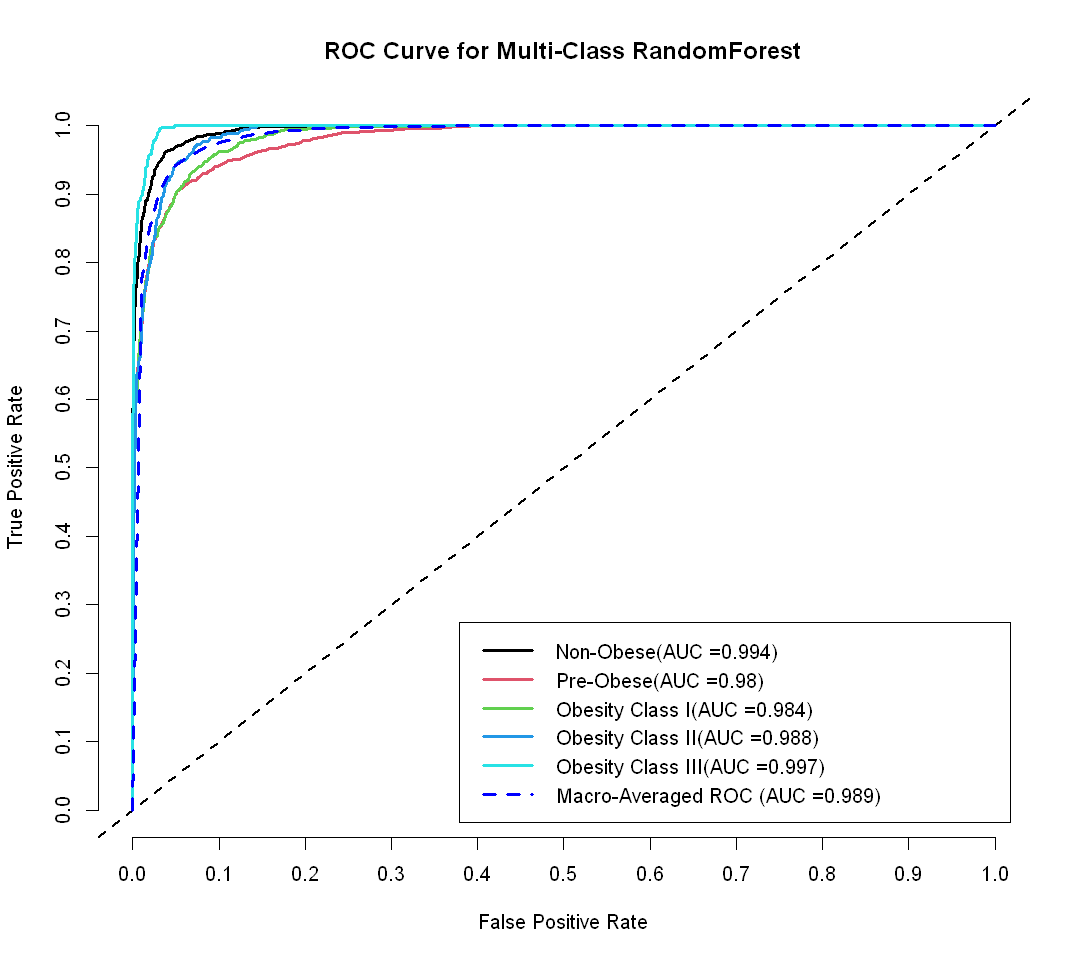

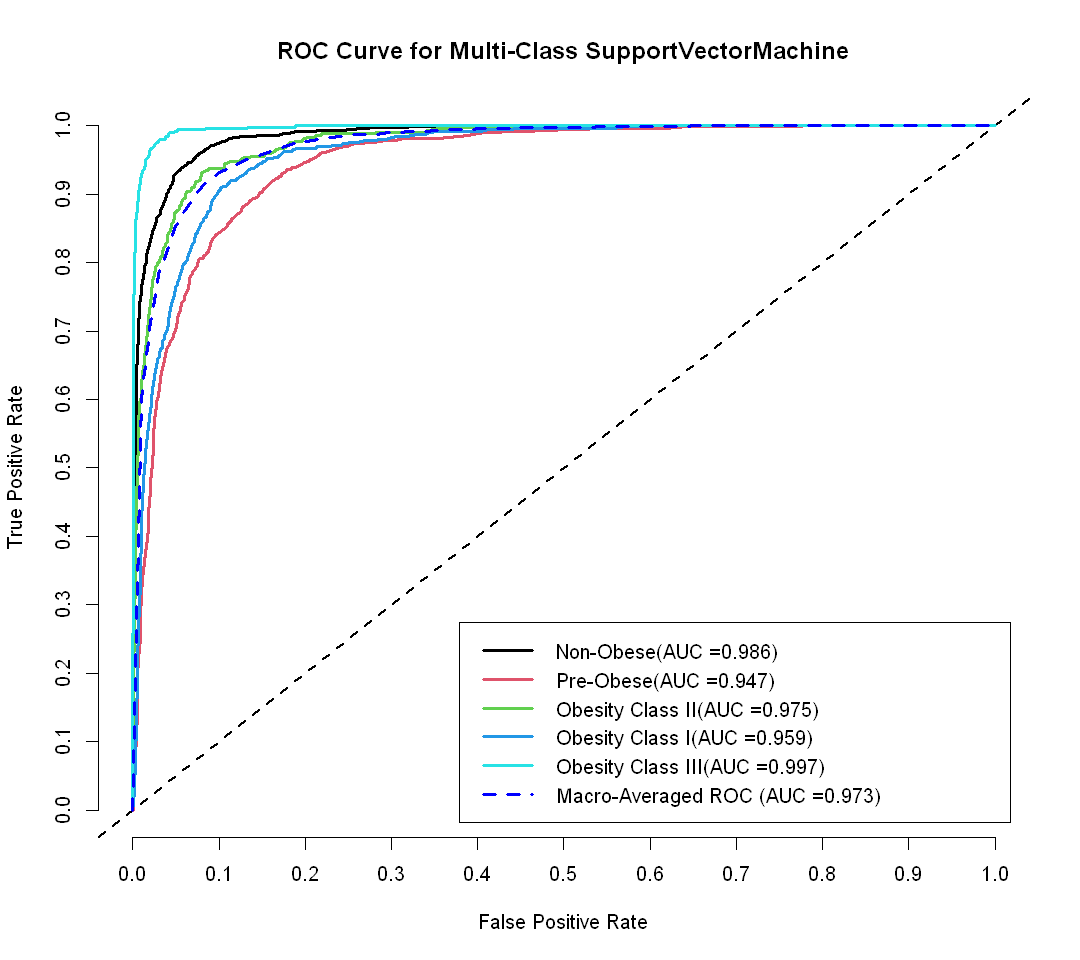

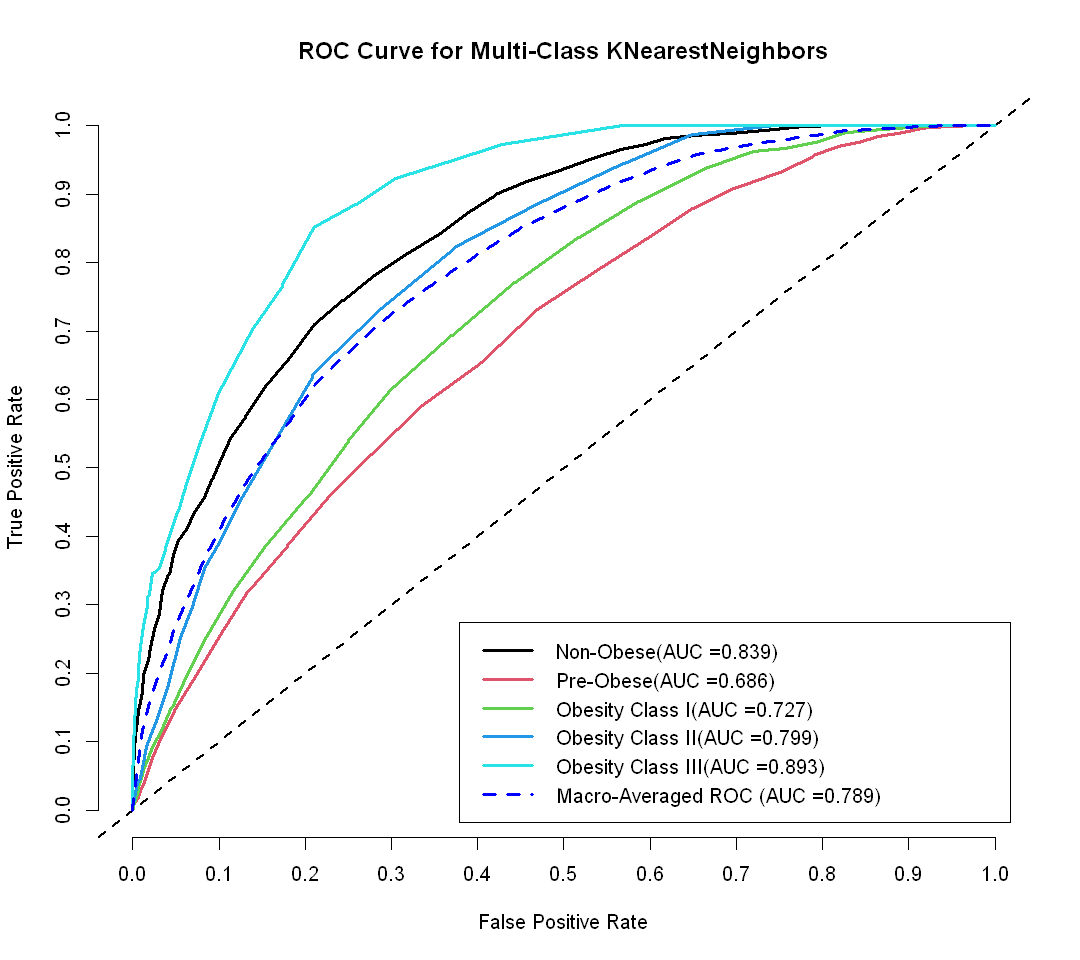

In [181]:
# List of models
models <- list(
  polytomousLogisticRegression = PLR_model, 
  DecisionTree = DT_model, 
  RandomForest = RF_model,
  SupportVectorMachine = SVM_model,
  KNearestNeighbors = KNN_model
  )

# Initialize a list to store AUC values for each model
model_auc_results <- list()

# Loop through models
for (model_name in names(models)) {
  # Generate predicted probabilities for the test data
  if (model_name == "SupportVectorMachine") {
    # Extract probabilities for SVM using attr
    svm_predictions <- predict(models[[model_name]], newdata = normalized_train_data, probability = TRUE)
    predictions <- attr(svm_predictions, "probabilities")
  } else {
    # Default predict method with type = "prob"
    predictions <- predict(models[[model_name]], newdata = normalized_train_data, type = "prob")
  }
  
  # Ensure predictions are in matrix format
  if (is.data.frame(predictions)) predictions <- as.matrix(predictions)
  
  # Initialize a vector to store AUC values for this model
  auc_values <- numeric(ncol(predictions))
  
  # Plot setup
  par(bg = "white")
  plot.new()
  plot.window(xlim = c(0, 1), ylim = c(0, 1))
  axis(1, at = seq(0, 1, by = 0.1))
  axis(2, at = seq(0, 1, by = 0.1))
  title(main = paste("ROC Curve for Multi-Class", model_name), 
        xlab = "False Positive Rate", ylab = "True Positive Rate")
  
  # Add y = x line (dashed and black)
  abline(a = 0, b = 1, col = "black", lty = 2, lwd = 2)
  
  # Initialize legend text
  legend_text <- character(ncol(predictions))
  
  # Initialize macro-average TPR and FPR for all classes
  macro_tpr <- rep(0, 101)
  macro_fpr <- seq(0, 1, length.out = 101)
  
  # Loop through each class to calculate ROC and AUC
  for (i in seq_len(ncol(predictions))) {
    # Extract true labels and predicted probabilities for the current class
    true_labels <- ifelse(normalized_train_data$Obesity_Category == colnames(predictions)[i], 1, 0)
    pred_probs <- predictions[, i]
    
    # Create a prediction object
    pred <- prediction(pred_probs, true_labels)
    
    # Create a performance object for the ROC curve
    perf <- performance(pred, "tpr", "fpr")
    
    # Remove duplicate FPR values for interpolation
    fpr_tpr <- data.frame(FPR = perf@x.values[[1]], TPR = perf@y.values[[1]])
    fpr_tpr <- fpr_tpr[!duplicated(fpr_tpr$FPR), ]
    
    # Interpolate TPR at uniform FPR points for macro-average calculation
    tpr_interp <- approx(fpr_tpr$FPR, fpr_tpr$TPR, xout = macro_fpr, rule = 2)$y
    macro_tpr <- macro_tpr + tpr_interp / ncol(predictions)
    
    # Plot the ROC curve for this class (bold line)
    lines(perf@x.values[[1]], perf@y.values[[1]], col = i, type = "l", lwd = 3)
    
    # Calculate the AUC for this class
    perf_auc <- performance(pred, "auc")
    auc_values[i] <- as.numeric(perf_auc@y.values)
    
    # Add AUC to the legend text
    legend_text[i] <- paste0(colnames(predictions)[i], "(AUC =", round(auc_values[i], 3), ")")
  }
  
  # Plot macro-averaged ROC curve (dashed bold line)
  lines(macro_fpr, macro_tpr, col = "blue", lty = 2, lwd = 3)
  
  # Add macro-averaged AUC to the legend text
  macro_auc <- mean(auc_values)
  legend_text <- c(legend_text, paste0("Macro-Averaged ROC (AUC =", round(macro_auc, 3), ")"))
  
  # Add legend to the plot
  legend("bottomright", 
        legend = legend_text, 
        col = c(seq_len(ncol(predictions)), "blue"), 
        lty = c(rep(1, ncol(predictions)), 2), 
        lwd = 3, 
        cex = 1,        # Reduce text size
        inset = 0.02,     # Adjust position
        box.lty = 1,      # Keep the box but thinner
        box.col = "black" # Box color (optional, or remove the box with box.lty = 0)
  )
  
  # Calculate Macro-Averaged AUC for the model
  average_auc <- mean(auc_values)
 
  # Store AUC values for this model
  model_auc_results[[model_name]] <- list(
    AUC_by_Class = auc_values,
    Macro_Averaged_AUC = average_auc
  )
}

<p style="text-align: justify;">
The code creates a data frame to store key performance metrics for three models. The performance metrics include Accuracy, Precision, Sensitivity (Recall), AUC (Area Under the Curve), and F1-Score. Each metric for the models is rounded to four decimal places.
<p>

In [172]:
# Create a data frame for key performance metrics
performance_table <- data.frame(
  KPI_test = c("Accuracy", "Macro F1-Score", "AUC"),
  PLR = round(c(
    results[["polytomousLogisticRegression"]][["Accuracy"]],
    results[["polytomousLogisticRegression"]][["Macro_F1"]],
    model_auc_results[["polytomousLogisticRegression"]][["Macro_Averaged_AUC"]]
  ), 4),
  DT = round(c(
    results[["DecisionTree"]][["Accuracy"]],
    results[["DecisionTree"]][["Macro_F1"]],
    model_auc_results[["DecisionTree"]][["Macro_Averaged_AUC"]]

  ), 4),
  RF = round(c(
    results[["RandomForest"]][["Accuracy"]],
    results[["RandomForest"]][["Macro_F1"]],
    model_auc_results[["RandomForest"]][["Macro_Averaged_AUC"]]

  ), 4),
  SVM = round(c(
    results[["SupportVectorMachine"]][["Accuracy"]],
    results[["SupportVectorMachine"]][["Macro_F1"]],
    model_auc_results[["SupportVectorMachine"]][["Macro_Averaged_AUC"]]

  ), 4),
  KNN = round(c(
    results[["KNearestNeighbors"]][["Accuracy"]],
    results[["KNearestNeighbors"]][["Macro_F1"]],
    model_auc_results[["KNearestNeighbors"]][["Macro_Averaged_AUC"]]

  ), 4)
)

# Print the performance table
performance_table

KPI_test,PLR,DT,RF,SVM,KNN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Accuracy,0.6735,0.6639,0.7251,0.7155,0.4405
Macro F1-Score,0.6021,0.6425,0.7039,0.6939,0.3541
AUC,0.9238,0.9069,0.9887,0.9729,0.7888


<p style="text-align: justify;">
The code creates a bar plot to compare the performance of three models (PLR, DT, and RF) across the different metrics. This visualization is helpful for visually comparing the performance of different models across various key metrics, aiding in model evaluation and selection.
<p>

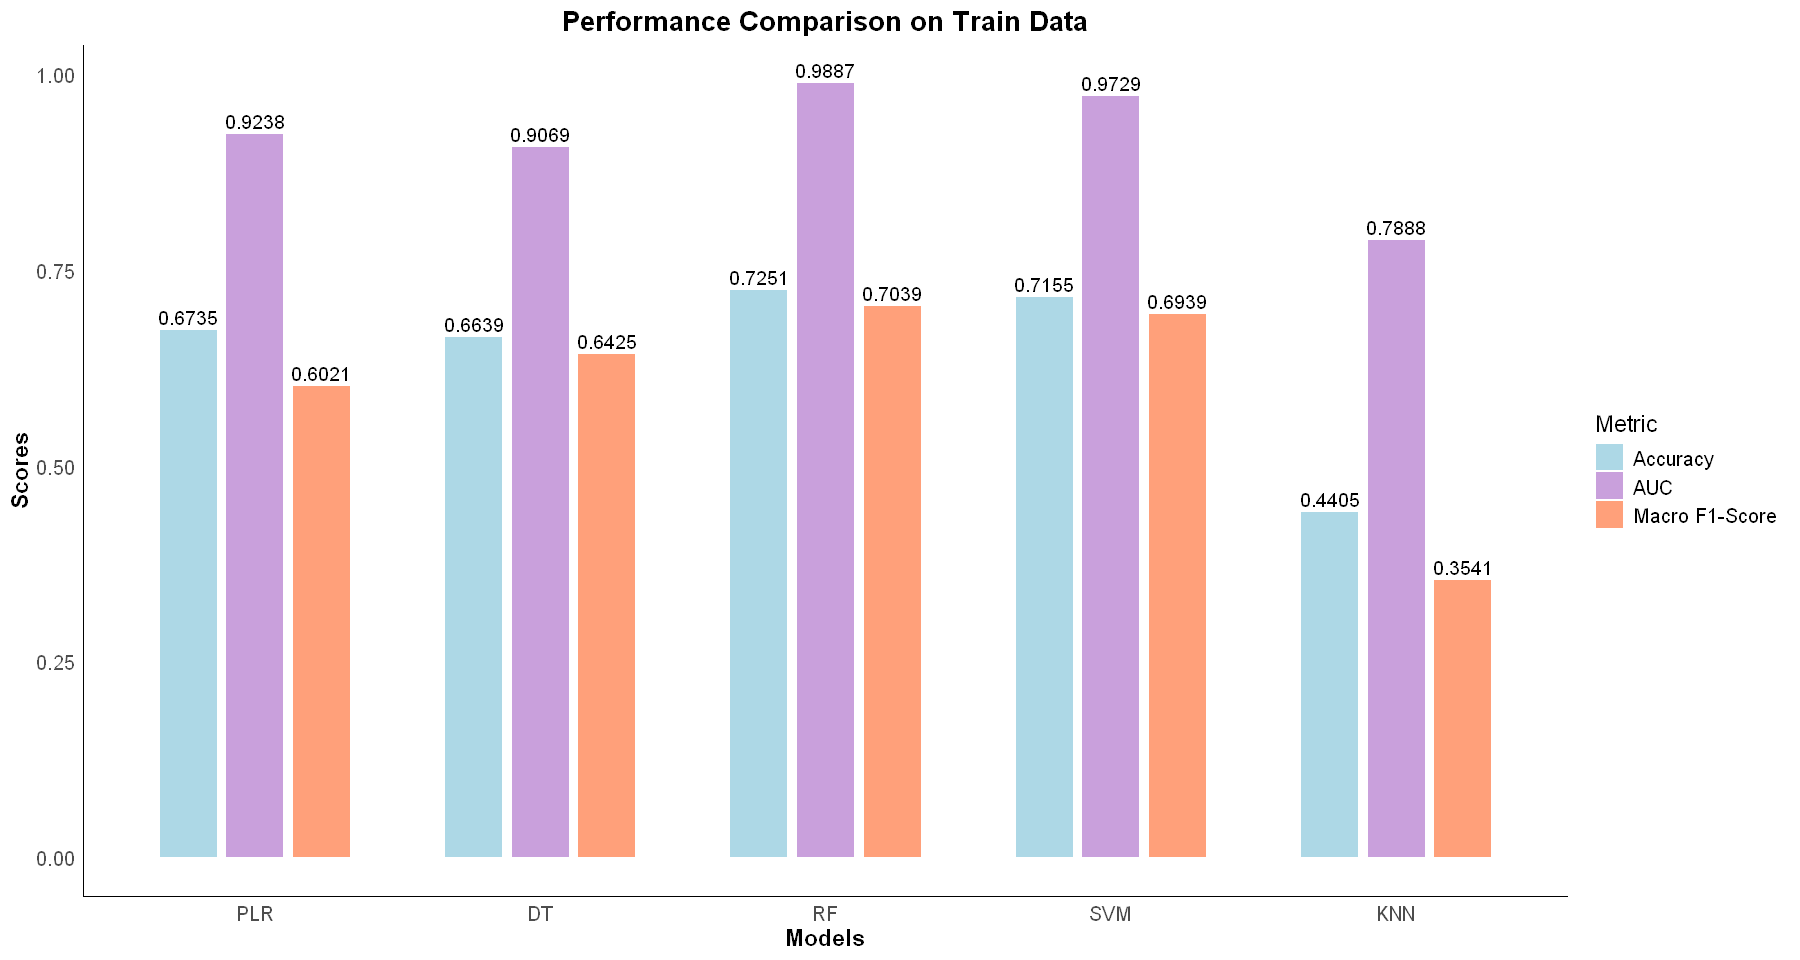

In [174]:
# Reshape the data for ggplot
performance_table_melted <- melt(performance_table, id.vars = "KPI_test", 
                                 variable.name = "Model", value.name = "Value")

# Define custom colors for the metrics
custom_colors <- c(
  "Accuracy" = "#ADD8E6",        # Light Blue
  "Macro Precision" = "#FFB6C1", # Light Pink
  "Macro Recall" = "#D3D3D3",    # Light Gray
  "Macro F1-Score" = "#FFA07A",  # Light Red
  "AUC" = "#C9A0DC"             # Light Purple
)

# Create the bar plot
plot <- ggplot(performance_table_melted, aes(x = Model, y = Value, fill = KPI_test)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = round(Value, 4)), 
            position = position_dodge(width = 0.7), 
            vjust = -0.4, size = 4, color = "black") +
  labs(title = "Performance Comparison on Train Data",
       x = "Models",
       y = "Scores",
       fill = "Metric") +
  scale_fill_manual(values = custom_colors) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black")
  )

# Adjust the size of the displayed plot
options(repr.plot.width = 15, repr.plot.height = 8)
print(plot)

### ***8.2. Test Data*** <a id = 8-2></a>

In [175]:
# List of models
models <- list(
  polytomousLogisticRegression = PLR_model, 
  DecisionTree = DT_model, 
  RandomForest = RF_model,
  SupportVectorMachine = SVM_model,
  KNearestNeighbors = KNN_model
  )
  
# Initialize a list to store results
results <- list()

# Iterate through each model and calculate metrics
for (model_name in names(models)) {
  cat("Evaluating model:", model_name, "\n")
  cat("--------------------------------------------------------------------\n\n")
  
  # Generate predictions for the test data
  predictions <- predict(models[[model_name]], newdata = normalized_test_data, type = "class")
  
  # Confusion matrix
  conf_matrix <- table(predictions, normalized_test_data$Obesity_Category)
  print(conf_matrix)
  
    # Confusion Matrix
    # ------------------------------------------------
    # Predicted/Actual   | Actual: Class A | Actual: Class B | Actual: Class C |
    # -------------------|-----------------|-----------------|-----------------|
    # Predicted: Class A | TP for Class A  | FP for Class B  | FP for Class C  |
    # Predicted: Class B | FN for Class A  | TP for Class B  | FP for Class C  |
    # Predicted: Class C | FN for Class A  | FN for Class B  | TP for Class C  |
    # ------------------------------------------------

  # Extract true positive, false positive, false negative counts
  true_positive <- diag(conf_matrix)                    # Diagonal values are true positives
  false_positive <- colSums(conf_matrix) - true_positive # Column sum minus true positives
  false_negative <- rowSums(conf_matrix) - true_positive # Row sum minus true positives
  
  # Precision, Recall, and F1-Score by Class
  precision <- true_positive / (true_positive + false_positive)
  recall <- true_positive / (true_positive + false_negative)
  
  # Handle NA values
  precision[is.na(precision)] <- 0
  recall[is.na(recall)] <- 0
  
  # F1-Scores
  f1_score <- 2 * (precision * recall) / (precision + recall)
  f1_score[is.na(f1_score)] <- 0
  
  # Macro-Averaged Precision, Recall, and F1-Score
  average_precision <- mean(precision)
  average_recall <- mean(recall)
  macro_f1 <- mean(f1_score)
  
  # Overall Accuracy
  accuracy <- sum(true_positive) / sum(conf_matrix)
  
  # Display results
  cat("\nPrecision by Class:\n")
  print(round(precision, 5))
  
  cat("Recall by Class:\n")
  print(round(recall, 5))
  
  cat("F1-Scores by Class:\n")
  print(round(f1_score, 5))
    
  # Display macro-averaged metrics and accuracy
  cat(paste("\nMacro-Averaged Precision:", round(average_precision, 5)), "\n")
  cat(paste("Macro-Averaged Recall:", round(average_recall, 5)), "\n")
  cat(paste("Macro-Averaged F1-Score:", round(macro_f1, 5)), "\n")
  cat(paste("Accuracy:", round(accuracy, 5)), "\n\n")
  
  # Save results to the list
  results[[model_name]] <- list(
    Macro_Precision = average_precision,
    Macro_Recall = average_recall,
    Macro_F1 = macro_f1,
    Accuracy = accuracy
  )
}

Evaluating model: polytomousLogisticRegression 
--------------------------------------------------------------------

                   
predictions         Non-Obese Pre-Obese Obesity Class I Obesity Class II
  Non-Obese               422        99               1                0
  Pre-Obese                55       281              85                0
  Obesity Class I           2        44             149               55
  Obesity Class II          0         4              30               35
  Obesity Class III         0         3              19               45
                   
predictions         Obesity Class III
  Non-Obese                         1
  Pre-Obese                         0
  Obesity Class I                  12
  Obesity Class II                 20
  Obesity Class III                93

Precision by Class:
        Non-Obese         Pre-Obese   Obesity Class I  Obesity Class II 
          0.88100           0.65197           0.52465           0.25926 
Obesity C

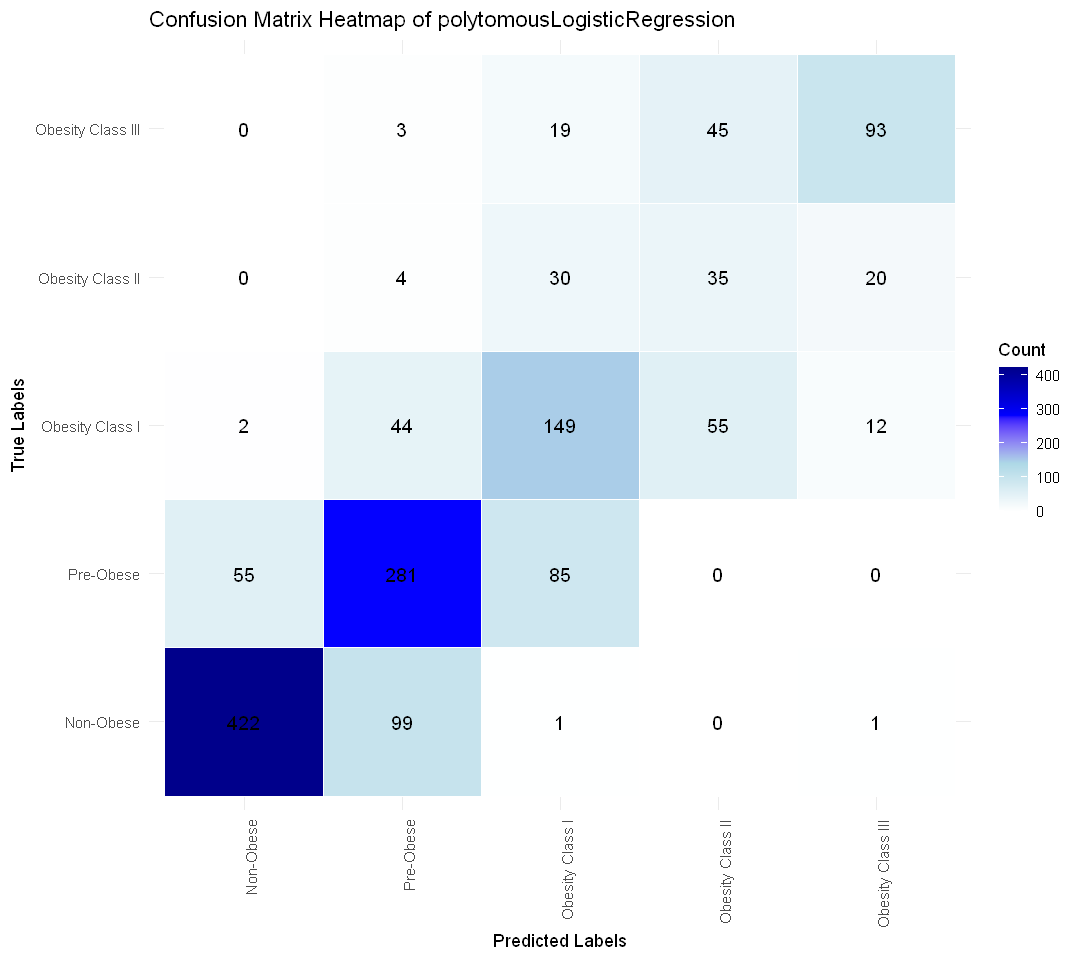

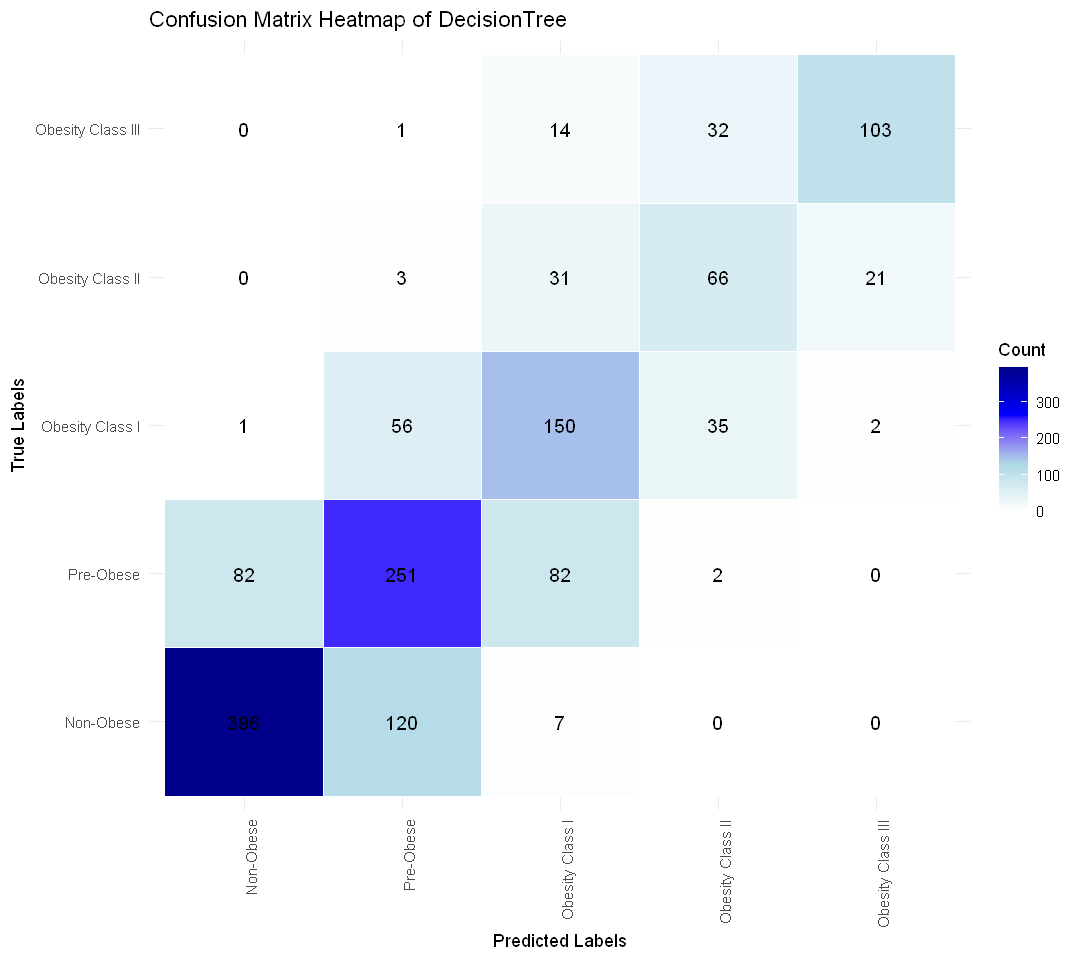

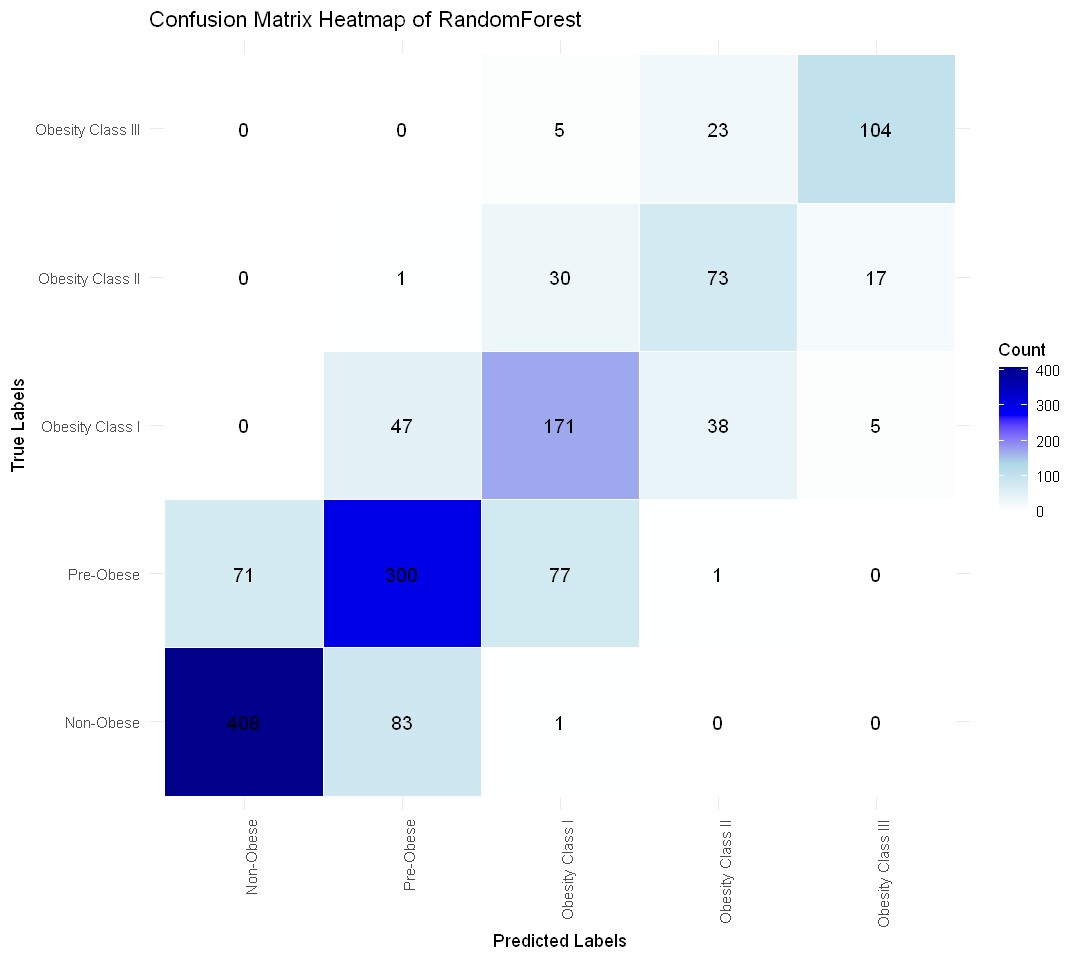

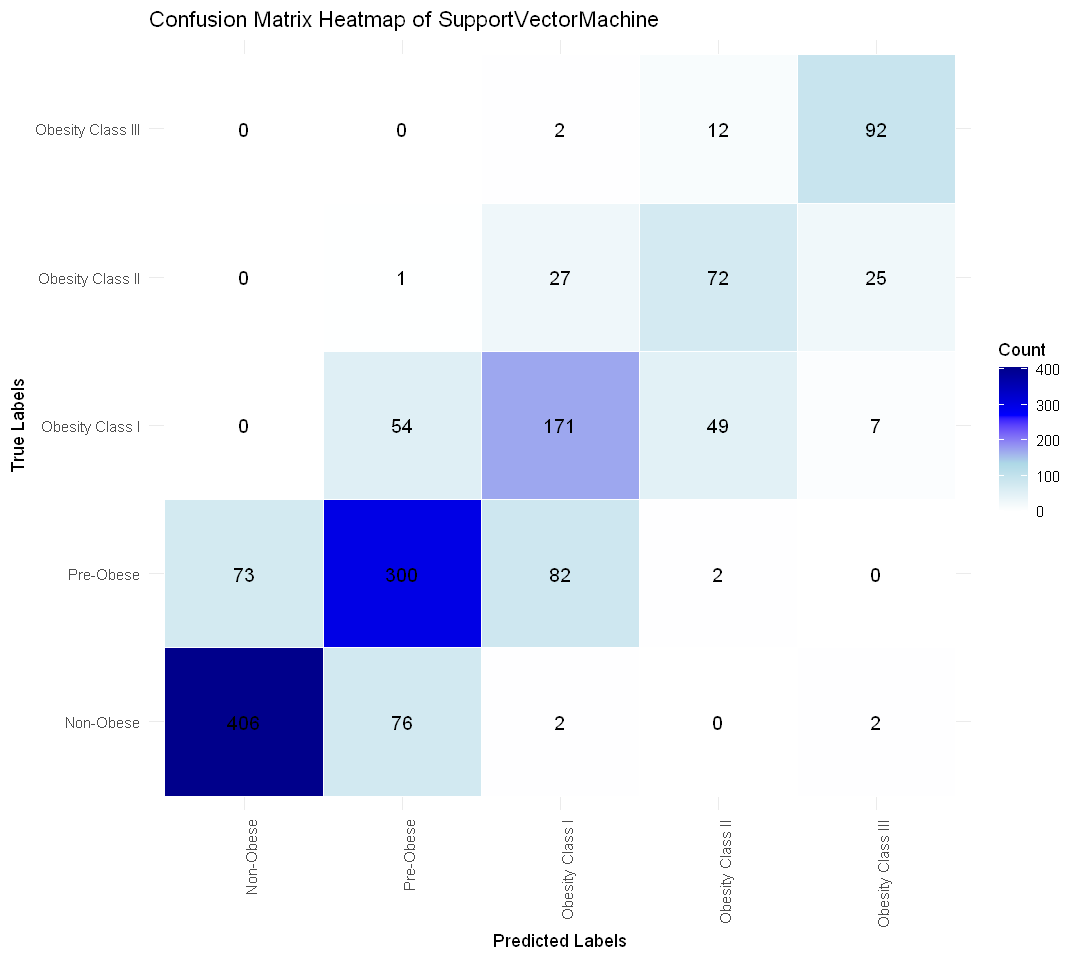

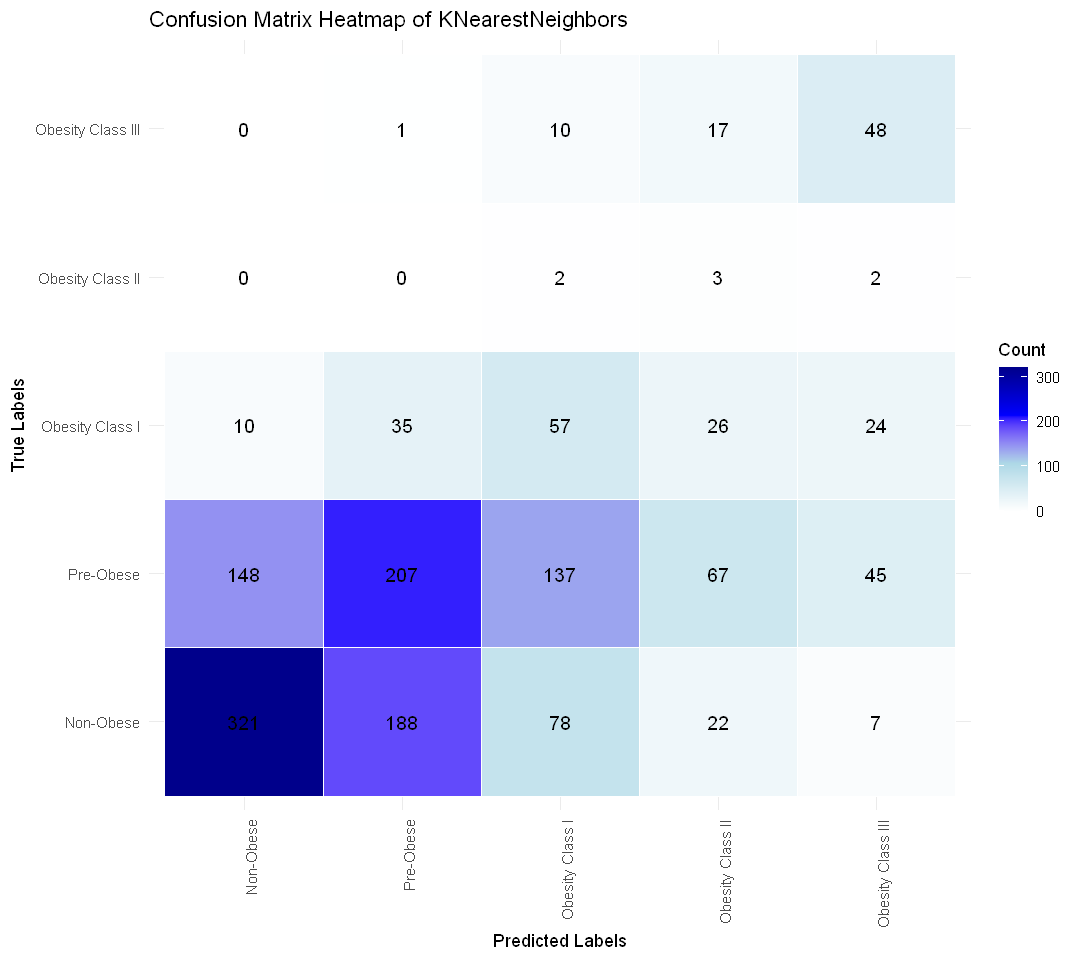

In [ ]:
# List of models
models <- list(
  polytomousLogisticRegression = PLR_model, 
  DecisionTree = DT_model, 
  RandomForest = RF_model,
  SupportVectorMachine = SVM_model,
  KNearestNeighbors = KNN_model
  )

# Define class labels for rows and columns
class_labels <- c("Non-Obese", "Pre-Obese", "Obesity Class I", "Obesity Class II", "Obesity Class III")

# Loop through models
for (model_name in names(models)) {  
  # Generate predictions
  predictions <- predict(models[[model_name]], newdata = normalized_test_data, type = "class")
  
  # Confusion matrix
  conf_matrix <- table(predictions, normalized_test_data$Obesity_Category)
  
  # Add row and column names (class labels)
  rownames(conf_matrix) <- class_labels
  colnames(conf_matrix) <- class_labels
  
  # Convert matrix to a dataframe for ggplot
  conf_df <- as.data.frame(as.table(as.matrix(conf_matrix)))
  
  # Rename columns for compatibility with ggplot
  colnames(conf_df) <- c("True Labels", "Predicted Labels", "Count")
  
  # Plot heatmap using ggplot
  plot <- ggplot(data = conf_df, aes(x = `Predicted Labels`, y = `True Labels`, fill = Count)) +
    geom_tile(color = "white") +
    scale_fill_gradientn(colors = c("white", "lightblue", "blue", "darkblue")) +
    geom_text(aes(label = Count), color = "black", size = 4) +
    labs(title = paste("Confusion Matrix Heatmap of", model_name),
         x = "Predicted Labels",
         y = "True Labels",
         fill = "Count") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
  
  # Adjust the size of the displayed plot
  options(repr.plot.width = 9, repr.plot.height = 8)
  print(plot)
}

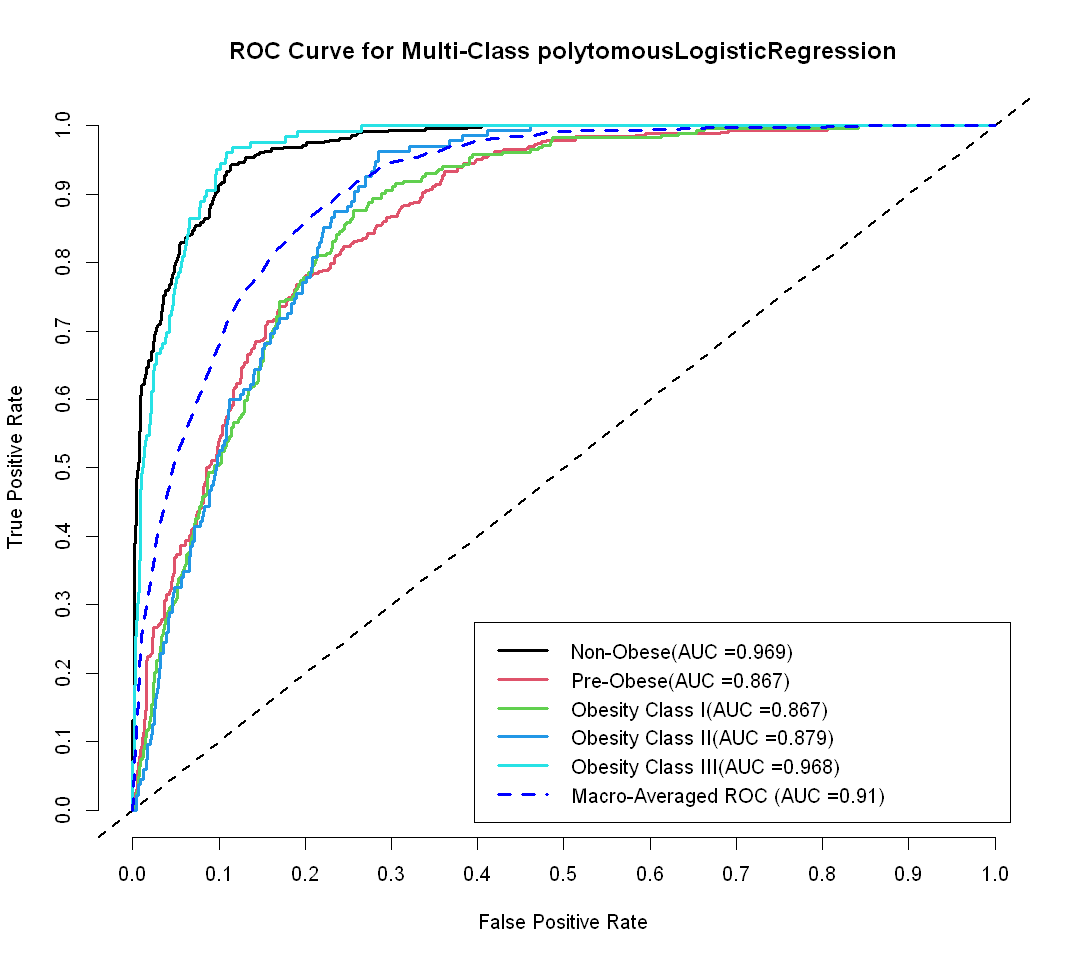

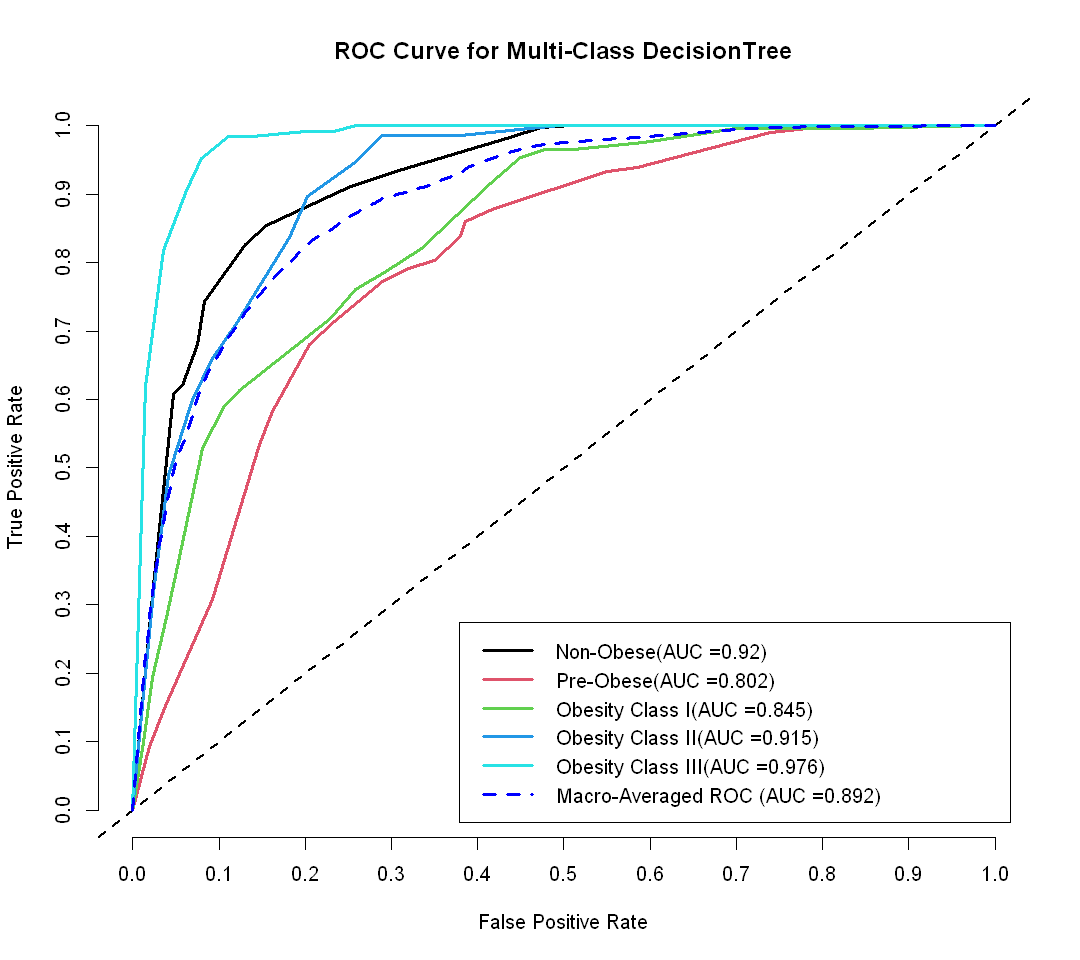

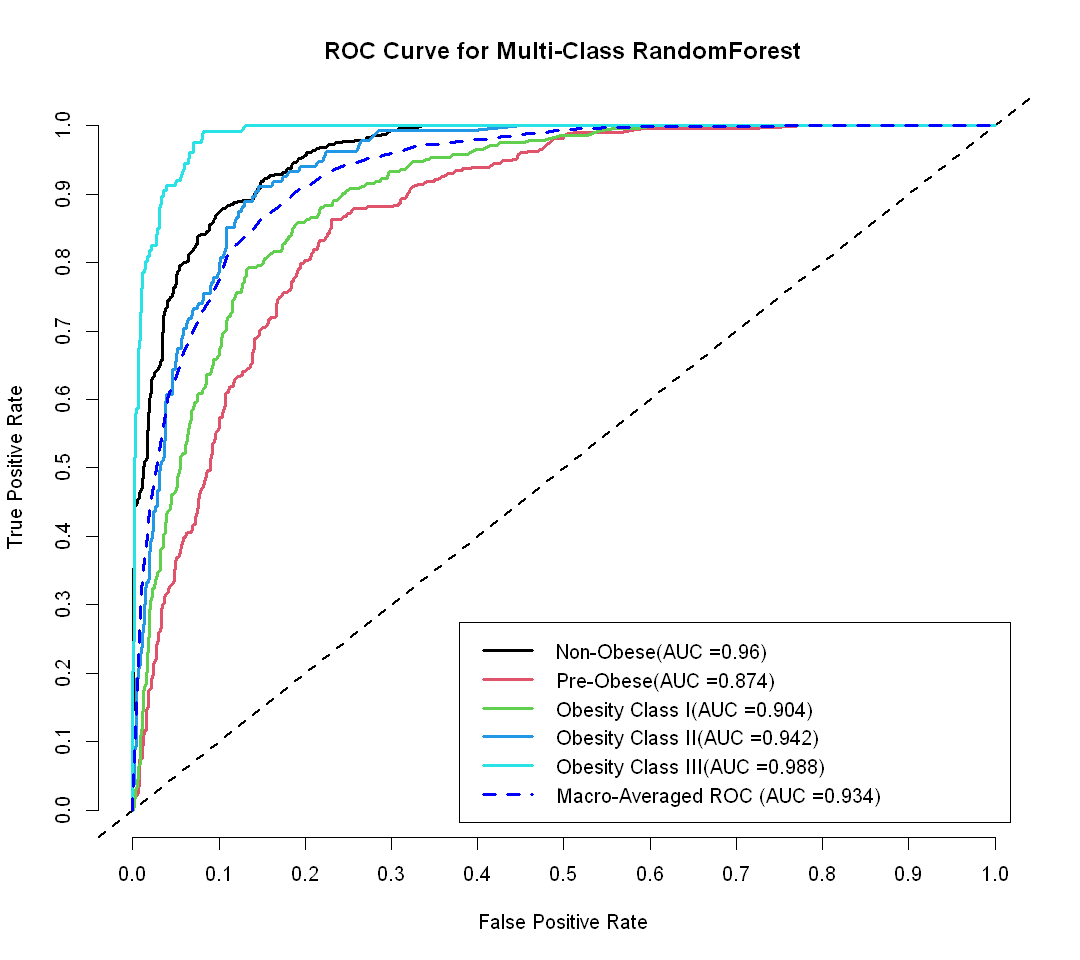

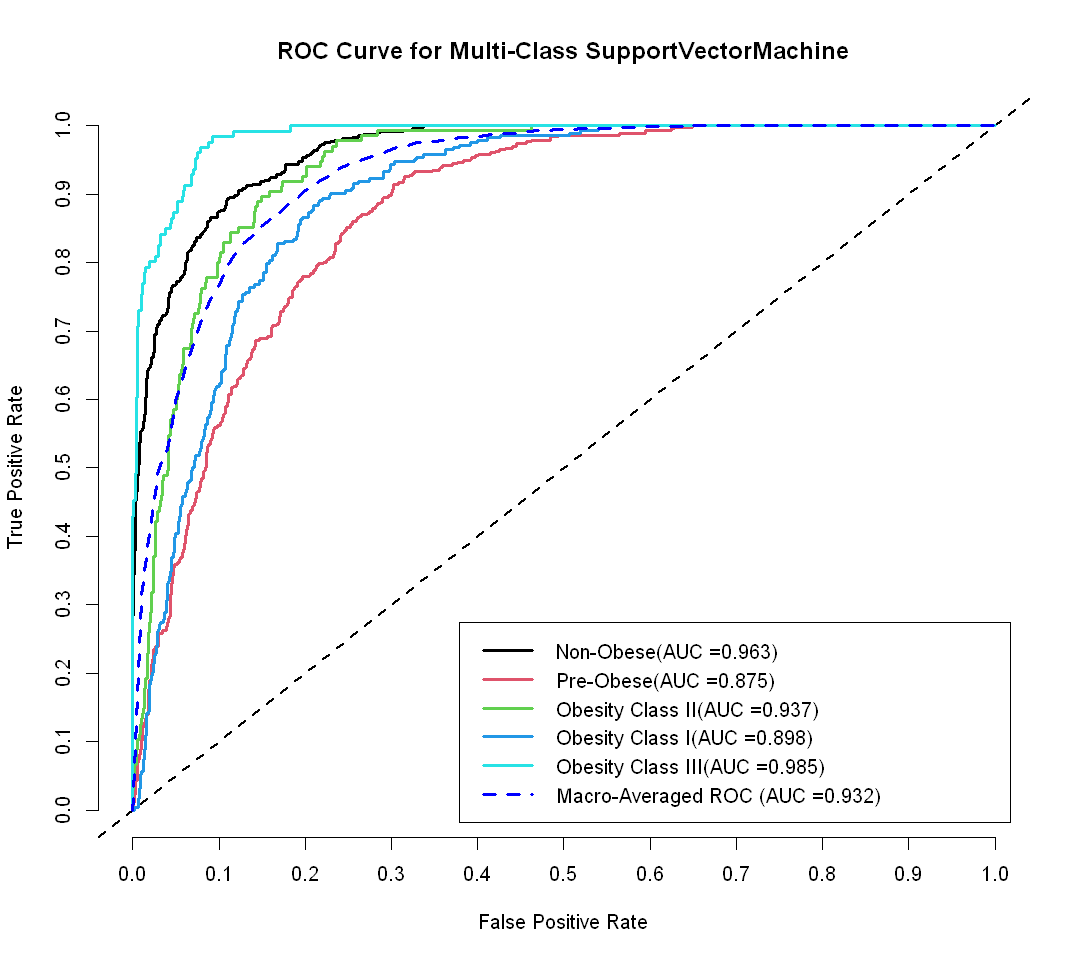

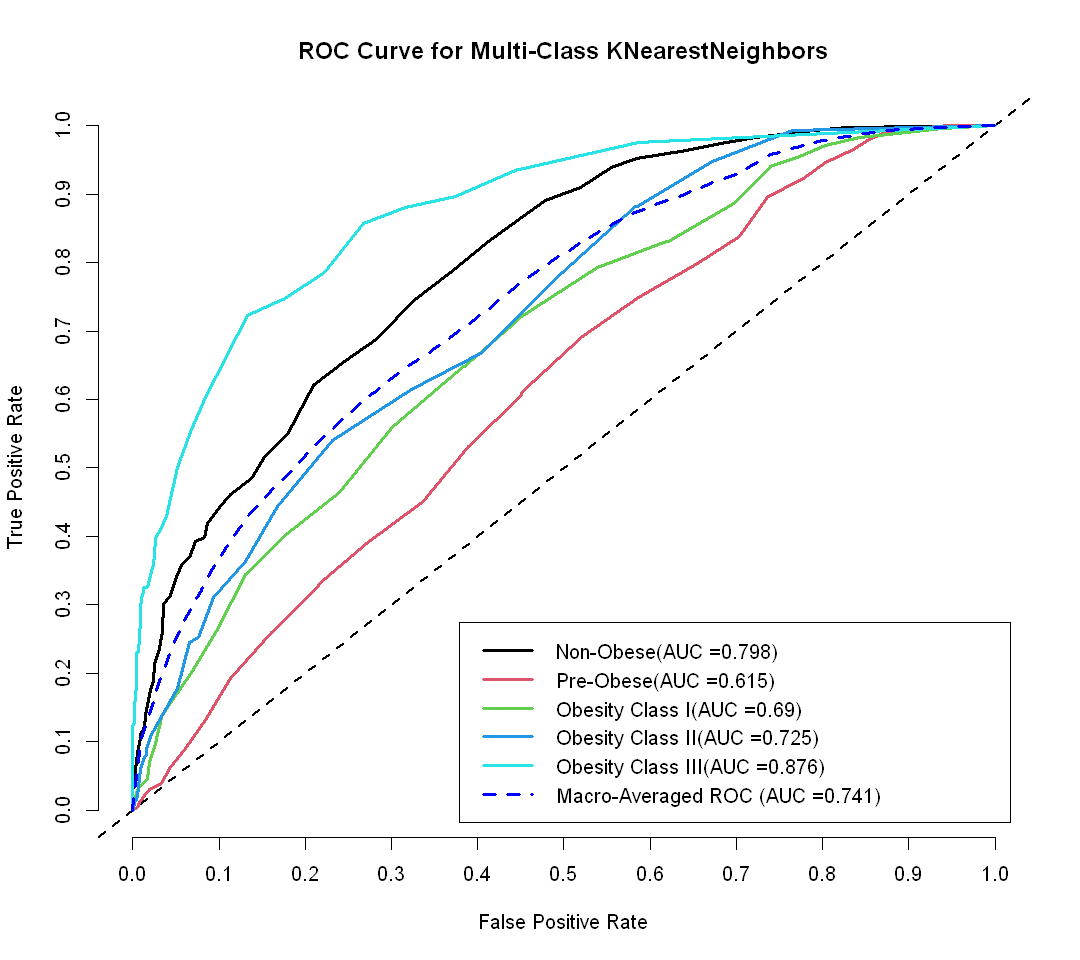

In [180]:
# List of models
models <- list(
  polytomousLogisticRegression = PLR_model, 
  DecisionTree = DT_model, 
  RandomForest = RF_model,
  SupportVectorMachine = SVM_model,
  KNearestNeighbors = KNN_model
  )

# Initialize a list to store AUC values for each model
model_auc_results <- list()

# Loop through models
for (model_name in names(models)) {
  # Generate predicted probabilities for the test data
  if (model_name == "SupportVectorMachine") {
    # Extract probabilities for SVM using attr
    svm_predictions <- predict(models[[model_name]], newdata = normalized_test_data, probability = TRUE)
    predictions <- attr(svm_predictions, "probabilities")
  } else {
    # Default predict method with type = "prob"
    predictions <- predict(models[[model_name]], newdata = normalized_test_data, type = "prob")
  }
  
  # Ensure predictions are in matrix format
  if (is.data.frame(predictions)) predictions <- as.matrix(predictions)
  
  # Initialize a vector to store AUC values for this model
  auc_values <- numeric(ncol(predictions))
  
  # Plot setup
  par(bg = "white")
  plot.new()
  plot.window(xlim = c(0, 1), ylim = c(0, 1))
  axis(1, at = seq(0, 1, by = 0.1))
  axis(2, at = seq(0, 1, by = 0.1))
  title(main = paste("ROC Curve for Multi-Class", model_name), 
        xlab = "False Positive Rate", ylab = "True Positive Rate")
  
  # Add y = x line (dashed and black)
  abline(a = 0, b = 1, col = "black", lty = 2, lwd = 2)
  
  # Initialize legend text
  legend_text <- character(ncol(predictions))
  
  # Initialize macro-average TPR and FPR for all classes
  macro_tpr <- rep(0, 101)
  macro_fpr <- seq(0, 1, length.out = 101)
  
  # Loop through each class to calculate ROC and AUC
  for (i in seq_len(ncol(predictions))) {
    # Extract true labels and predicted probabilities for the current class
    true_labels <- ifelse(normalized_test_data$Obesity_Category == colnames(predictions)[i], 1, 0)
    pred_probs <- predictions[, i]
    
    # Create a prediction object
    pred <- prediction(pred_probs, true_labels)
    
    # Create a performance object for the ROC curve
    perf <- performance(pred, "tpr", "fpr")
    
    # Remove duplicate FPR values for interpolation
    fpr_tpr <- data.frame(FPR = perf@x.values[[1]], TPR = perf@y.values[[1]])
    fpr_tpr <- fpr_tpr[!duplicated(fpr_tpr$FPR), ]
    
    # Interpolate TPR at uniform FPR points for macro-average calculation
    tpr_interp <- approx(fpr_tpr$FPR, fpr_tpr$TPR, xout = macro_fpr, rule = 2)$y
    macro_tpr <- macro_tpr + tpr_interp / ncol(predictions)
    
    # Plot the ROC curve for this class (bold line)
    lines(perf@x.values[[1]], perf@y.values[[1]], col = i, type = "l", lwd = 3)
    
    # Calculate the AUC for this class
    perf_auc <- performance(pred, "auc")
    auc_values[i] <- as.numeric(perf_auc@y.values)
    
    # Add AUC to the legend text
    legend_text[i] <- paste0(colnames(predictions)[i], "(AUC =", round(auc_values[i], 3), ")")
  }
  
  # Plot macro-averaged ROC curve (dashed bold line)
  lines(macro_fpr, macro_tpr, col = "blue", lty = 2, lwd = 3)
  
  # Add macro-averaged AUC to the legend text
  macro_auc <- mean(auc_values)
  legend_text <- c(legend_text, paste0("Macro-Averaged ROC (AUC =", round(macro_auc, 3), ")"))
  
  # Add legend to the plot
  legend("bottomright", 
        legend = legend_text, 
        col = c(seq_len(ncol(predictions)), "blue"), 
        lty = c(rep(1, ncol(predictions)), 2), 
        lwd = 3, 
        cex = 1,        # Reduce text size
        inset = 0.02,     # Adjust position
        box.lty = 1,      # Keep the box but thinner
        box.col = "black" # Box color (optional, or remove the box with box.lty = 0)
  )
  
  # Calculate Macro-Averaged AUC for the model
  average_auc <- mean(auc_values)
 
  # Store AUC values for this model
  model_auc_results[[model_name]] <- list(
    AUC_by_Class = auc_values,
    Macro_Averaged_AUC = average_auc
  )
}

In [183]:
# Create a data frame for key performance metrics
performance_table <- data.frame(
  KPI_test = c("Accuracy", "Macro F1-Score", "AUC"),
  PLR = round(c(
    results[["polytomousLogisticRegression"]][["Accuracy"]],
    results[["polytomousLogisticRegression"]][["Macro_F1"]],
    model_auc_results[["polytomousLogisticRegression"]][["Macro_Averaged_AUC"]]
  ), 4),
  DT = round(c(
    results[["DecisionTree"]][["Accuracy"]],
    results[["DecisionTree"]][["Macro_F1"]],
    model_auc_results[["DecisionTree"]][["Macro_Averaged_AUC"]]

  ), 4),
  RF = round(c(
    results[["RandomForest"]][["Accuracy"]],
    results[["RandomForest"]][["Macro_F1"]],
    model_auc_results[["RandomForest"]][["Macro_Averaged_AUC"]]

  ), 4),
  SVM = round(c(
    results[["SupportVectorMachine"]][["Accuracy"]],
    results[["SupportVectorMachine"]][["Macro_F1"]],
    model_auc_results[["SupportVectorMachine"]][["Macro_Averaged_AUC"]]

  ), 4),
  KNN = round(c(
    results[["KNearestNeighbors"]][["Accuracy"]],
    results[["KNearestNeighbors"]][["Macro_F1"]],
    model_auc_results[["KNearestNeighbors"]][["Macro_Averaged_AUC"]]

  ), 4)
)

# Print the performance table
performance_table

KPI_test,PLR,DT,RF,SVM,KNN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Accuracy,0.6735,0.6639,0.7251,0.7155,0.4440
Macro F1-Score,0.6021,0.6425,0.7039,0.6939,0.3579
AUC,0.9238,0.9069,0.9887,0.9729,0.7888


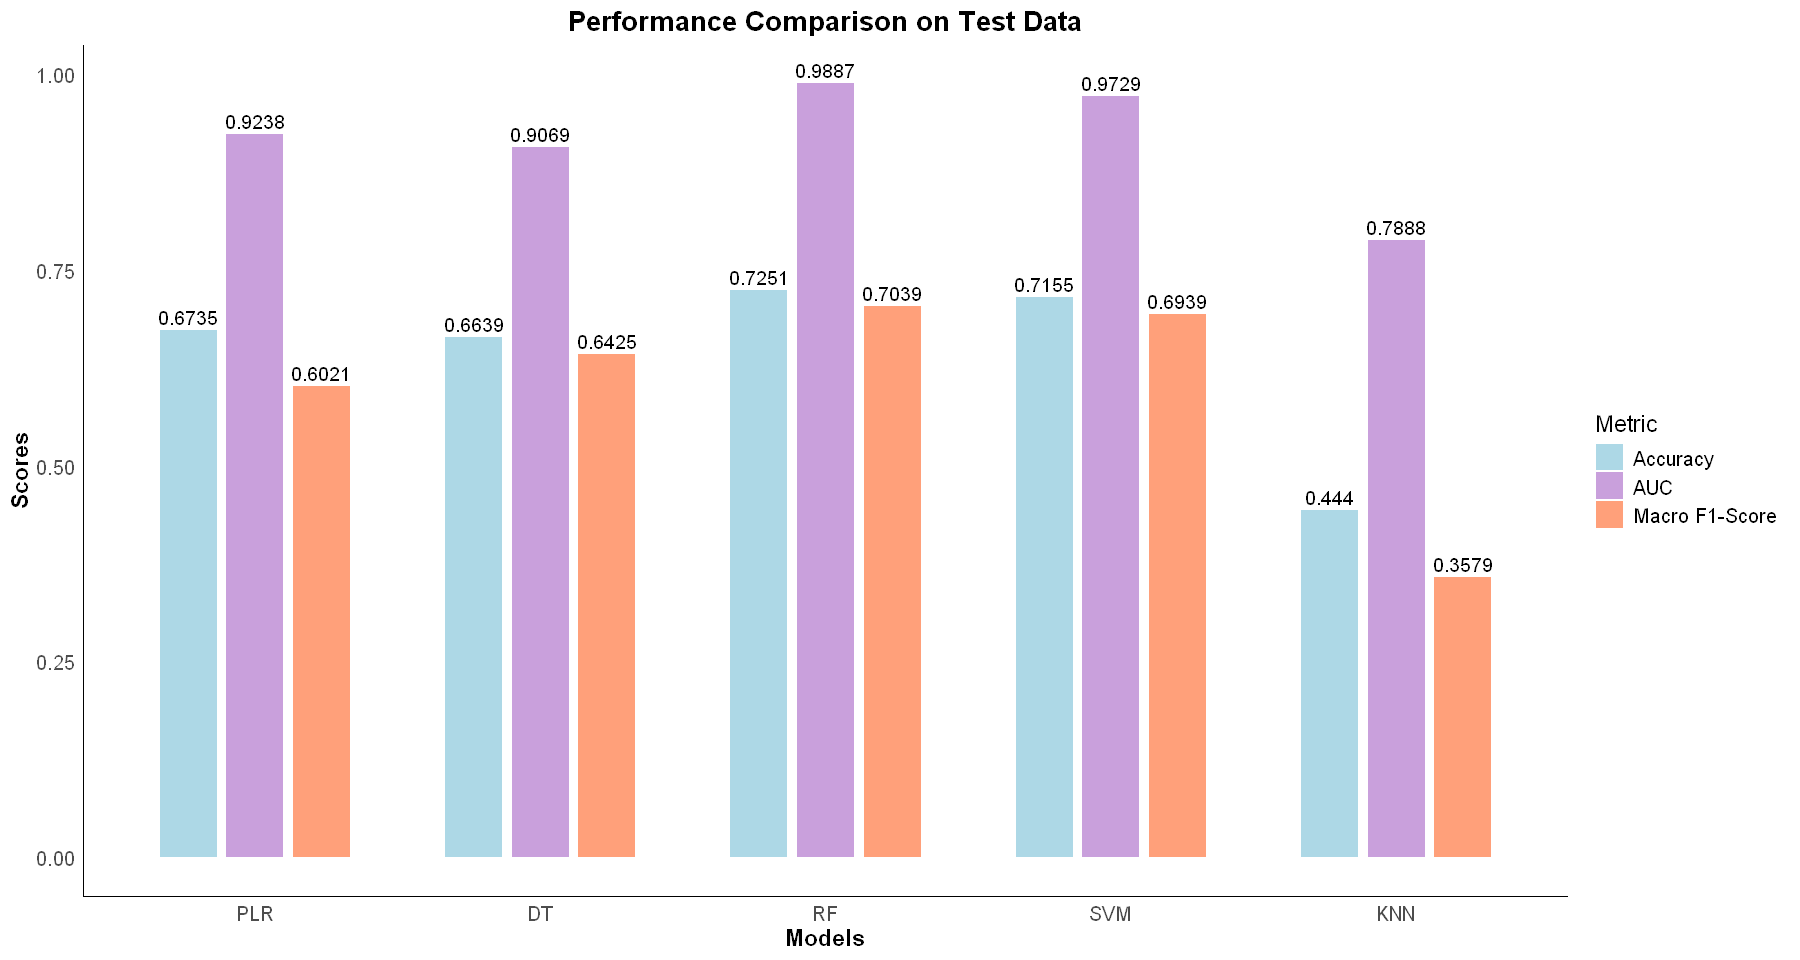

In [185]:
# Reshape the data for ggplot
performance_table_melted <- melt(performance_table, id.vars = "KPI_test", 
                                 variable.name = "Model", value.name = "Value")

# Define custom colors for the metrics
custom_colors <- c(
  "Accuracy" = "#ADD8E6",        # Light Blue
  "Macro Precision" = "#FFB6C1", # Light Pink
  "Macro Recall" = "#D3D3D3",    # Light Gray
  "Macro F1-Score" = "#FFA07A",  # Light Red
  "AUC" = "#C9A0DC"             # Light Purple
)

# Create the bar plot
plot <- ggplot(performance_table_melted, aes(x = Model, y = Value, fill = KPI_test)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = round(Value, 4)), 
            position = position_dodge(width = 0.7), 
            vjust = -0.4, size = 4, color = "black") +
  labs(title = "Performance Comparison on Test Data",
       x = "Models",
       y = "Scores",
       fill = "Metric") +
  scale_fill_manual(values = custom_colors) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black")
  )

# Adjust the size of the displayed plot
options(repr.plot.width = 15, repr.plot.height = 8)
print(plot)

## **9. Best Method Selection** <a id = 9></a>

<p style="text-align: justify;">
The code constructs a decision matrix that organizes performance metrics for five machine learning models: "Polytomous Logistic Regression," "Decision Tree," "Random Forest," "Support Vector Machine," and "K-Nearest Neighbors." Each column in the matrix corresponds to a criterion such as Accuracy, Macro-Precision, Macro-Recall, Macro-F1, and AUC. Row names are assigned to identify each model clearly. This matrix serves as a structured input for further multi-criteria decision-making analysis, enabling comparisons and rankings of the models based on their performance metrics.
</p>

In [201]:
# Construct the Decision Matrix
decision_matrix <- data.frame(
  "Accuracy" = c(
    results[["polytomousLogisticRegression"]][["Accuracy"]],
    results[["DecisionTree"]][["Accuracy"]],
    results[["RandomForest"]][["Accuracy"]],
    results[["SupportVectorMachine"]][["Accuracy"]],
    results[["KNearestNeighbors"]][["Accuracy"]]
  ),
  "Macro-Precision" = c(
    results[["polytomousLogisticRegression"]][["Macro_Precision"]],
    results[["DecisionTree"]][["Macro_Precision"]],
    results[["RandomForest"]][["Macro_Precision"]],
    results[["SupportVectorMachine"]][["Macro_Precision"]],
    results[["KNearestNeighbors"]][["Macro_Precision"]]
  ),
  "Macro-Recall" = c(
    results[["polytomousLogisticRegression"]][["Macro_Recall"]],
    results[["DecisionTree"]][["Macro_Recall"]],
    results[["RandomForest"]][["Macro_Recall"]],
    results[["SupportVectorMachine"]][["Macro_Recall"]],
    results[["KNearestNeighbors"]][["Macro_Recall"]]
  ),
  "Macro-F1" = c(
    results[["polytomousLogisticRegression"]][["Macro_F1"]],
    results[["DecisionTree"]][["Macro_F1"]],
    results[["RandomForest"]][["Macro_F1"]],
    results[["SupportVectorMachine"]][["Macro_F1"]],
    results[["KNearestNeighbors"]][["Macro_F1"]]
  ),
  "AUC" = c(
    model_auc_results[["polytomousLogisticRegression"]][["Macro_Averaged_AUC"]],
    model_auc_results[["DecisionTree"]][["Macro_Averaged_AUC"]],
    model_auc_results[["RandomForest"]][["Macro_Averaged_AUC"]],
    model_auc_results[["SupportVectorMachine"]][["Macro_Averaged_AUC"]],
    model_auc_results[["KNearestNeighbors"]][["Macro_Averaged_AUC"]]
  )
)

# Add row names for clarity
rownames(decision_matrix) <- c(
  "Polytomous Logistic Regression",
  "Decision Tree",
  "Random Forest",
  "Support Vector Machine",
  "K-Nearest Neighbors"
)

# Print the Decision Matrix
(decision_matrix)

,Accuracy,Macro.Precision,Macro.Recall,Macro.F1,AUC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Polytomous Logistic Regression,0.6735395,0.6109953,0.6035105,0.6021154,0.9238352
Decision Tree,0.6639175,0.6487214,0.6411928,0.6425168,0.9069100
Random Forest,0.7250859,0.7017346,0.7075941,0.7038940,0.9887251
Support Vector Machine,0.7154639,0.6818519,0.7088623,0.6938772,0.9729489
K-Nearest Neighbors,0.4439863,0.3558884,0.4532149,0.3579284,0.7888491


<p style="text-align: justify;">
The code defines a Shannon Entropy Function to calculate the weights for multiple criteria based on the given decision matrix. It first computes a normalization constant based on the number of rows in the matrix. Then, it normalizes each column of the matrix by dividing each element by the column sum. For each column, the entropy is calculated, avoiding undefined values for logarithms by using conditional checks. The divergence is then computed, and the weights are determined by normalizing the divergence values. Finally, the weights are labeled using the column names of the decision matrix and returned. These weights are displayed as a data frame, enabling analysis of the relative importance of each criterion.
</p>

In [245]:
# Shannon Entropy Function
Shannon_Entropy <- function(DM) {
  
  # Define normalization constant K
  K <- 1 / log(nrow(DM))
  
  # Normalize the decision matrix
  Norm_DM <- apply(DM, 2, function(col) round(col / sum(col), 3))
  
  # Calculate entropy (Ej) for each column
  Ej <- apply(Norm_DM, 2, function(col) {
    S <- sum(ifelse(col > 0, col * log(col), 0)) # Avoid log(0) by using ifelse
    round(-K * S, 3)
  })
  
  # Calculate divergence (dj)
  dj <- 1 - Ej
  
  # Calculate weights (Wj)
  Wj <- round(dj / sum(dj), 4)
  
  # Assign criteria names to weights
  names(Wj) <- colnames(DM)
  
  return(Wj)
}

# Calculate Shannon Entropy weights
Weights <- Shannon_Entropy(decision_matrix)
cat("Weights calculated using Shannon Entropy:\n")
as.data.frame(Weights)

Weights calculated using Shannon Entropy:


,Weights
,<dbl>
Accuracy,0.1875
Macro.Precision,0.3125
Macro.Recall,0.1458
Macro.F1,0.3125
AUC,0.0417


<p style="text-align: justify;">
The code defines a Simple Additive Weighting (SAW) function to rank alternatives based on a decision matrix. The function first normalizes each column of the matrix based on its nature: beneficial (higher values preferred) or non-beneficial (lower values preferred). The normalization adjusts the values between 0 and 1. Then, it calculates a weighted score for each alternative by multiplying the normalized matrix by the weights vector. The row with the highest weighted score is identified as the best alternative. The function returns both the best alternative and the weighted scores for all alternatives. Finally, the code applies this function to the decision matrix, sorts the weighted scores in descending order, and displays the best model along with the sorted scores.
</p>

In [233]:
# SAW Function
SAW <- function(DM, Criteria_nature, Weights) {
  
  # Normalize the decision matrix
  for (i in seq_along(Criteria_nature)) {
    if (Criteria_nature[i] == 'NB') {
      # Normalize non-beneficial criteria (lower is better)
      DM[, i] <- min(DM[, i]) / DM[, i]
    } else {
      # Normalize beneficial criteria (higher is better)
      DM[, i] <- DM[, i] / max(DM[, i])
    }
  }
  
  # Compute the weighted normalized decision matrix
  Weighted_DM <- as.matrix(DM) %*% as.matrix(Weights)
  
  # Assign row names to the Weighted_DM for clarity
  names(Weighted_DM) <- rownames(DM)
  
  # Find the best alternative (maximum weighted score)
  best_alternative <- names(which.max(Weighted_DM))
  
  # Return the best alternative and the weighted scores
  return(list(
    best_alternative = best_alternative,
    weighted_scores = Weighted_DM
  ))
}

# Apply SAW
Criteria_nature <- c("B", "B", "B", "B", "B")
result <- SAW(decision_matrix, Criteria_nature, Weights)

# Output the Best Model and Scores
cat("The best model based on SAW is:", result$best_alternative, "\n")
cat("Weighted scores for all models:\n")
sorted_scores <- as.data.frame(sort(result$weighted_scores, decreasing = TRUE))
colnames(sorted_scores) <- c("Weighted Score")
(sorted_scores)

The best model based on SAW is: Random Forest 
Weighted scores for all models:


,Weighted Score
,<dbl>
Random Forest,0.9997388
Support Vector Machine,0.9835550
Decision Tree,0.9159517
Polytomous Logistic Regression,0.8767229
K-Nearest Neighbors,0.5588557


***
PLOTS

In [41]:
# Create Bar chart for a factor variable split by Gender
#plot <- ggplot(complete_data, aes(x = Diet_Healthiness, fill = Gender)) + # Map fill to Gender
#    geom_bar(position = "identity", color = "black") +
#    facet_grid(. ~ Gender) +
#    labs(title = paste("Bar plot of Diet_Healthiness by Gender"),
#         x = "Diet_Healthiness",
#         y = "Count") +
#    scale_fill_manual(values = c("lightblue", "lightpink")) + # Custom colors
#    theme_minimal() +
#    theme(
#        axis.text.x = element_text(angle = 90, hjust = 1, size = 12) # Rotate x-axis labels
#   )
  
# Print the plot
#print(plot)

In [42]:
# Identify numeric variables in the dataset
#numeric_vars <- complete_data %>%
#  select(where(is.numeric)) %>%
#  colnames()

# Create box plots for each numeric variable split by Gender
#for (var in numeric_vars) {
  # Create a boxplot for the current numeric variable
#  plot <- ggplot(complete_data, aes_string(x = "Gender", y = var, fill = "Gender")) +
#    geom_boxplot() +
#    labs(title = paste("Box Plot of", var, "by Gender"),
#         x = "Gender",
#         y = var) +
#    scale_fill_manual(values = c("lightblue", "lightpink")) + # Custom colors
#    theme_minimal()
  
  # Print the plot
#  print(plot)